# <p style="text-align: center;">Calibration sur les données de Chong et Menberg (2018)</p>

#### Chargement des librairies Python

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import pytensor.tensor as pt
from pytensor.tensor.slinalg import cholesky
from functools import partial
from multiprocessing import Pool
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
import PredictionsMLR
import math
import random

#### Quelques réglages préliminaire

In [2]:
# Augmentation de la résolution des images affichées
%config InlineBackend.figure_format = 'retina'

# Fenêtre graphique avec grilles 
az.style.use("arviz-darkgrid")

# Initialisation de la graine utilisée pour générer les données
seed = 2024
rng = np.random.default_rng(seed)

#### Lecture des jeux de données

In [3]:
# Chemin où se trouvent les fichiers contenant les données
Path = "C:/Users/Cesi/Documents/CalibrationChong"

In [4]:
# Lecture des deux datasets
datafield = pd.read_csv(os.path.join(Path, "datafield.csv"), header = 0)
datacomp = pd.read_csv(os.path.join(Path, "datacomp.csv"), header = 0)

In [5]:
# Affichage des données observées
datafield

yf        xf1        xf2         xf3
0   1562   1.691667  37.930108  204.021505
1   1395   0.061012  51.191964  181.846726
2   1279   4.350672  50.607527  219.407258
3   1347   5.442639  56.034722  199.316667
4   1363  14.064247  44.780914  244.112903
5   1691  21.354583  37.579167  305.216667
6   1852  22.266398  49.415323  272.467742
7   1983  22.615054  42.755376  222.255376
8   1650  18.458056  53.500000  225.045833
9   1385   8.881452  54.770161  233.721774
10  1347   6.096667  42.076389  217.447222
11  1524   0.197043  48.176075  224.553763

#### Description des données

La sortie étudiée est la consommation electrique mensuelle. Les données ont été acquises sur 18 mois de Juillet 2012 à Décembre 2013. 12 mois ont été utilisés comme jeu de données d'entrainement contre 6 mois pour le jeu de données de test. Ici, nous n'avons accès qu'au jeu de données d'entrainement. Les variables observables sont-elles au nombre de 3, et correspondent à la température sèche exterieur, l'humidité exterieur relative et le taux de radiation solaire direct par unité d'aire. Au préalable, une analyse de sensibilité a été réalisée afin de déterminer les variables incertaines les plus influents sur le modèle parmi 14 variables. Ainsi, 3 variables incertaines ont été choisies pour notre jeu de données, l'efficacité des ventilateurs, la densité de puissance des équipements electriques et enfin l'infiltration.

Il y a ici deux jeux de données, le premier, datafield représente les données observées. La variable $y$ correspond à la consommation électrique mensuelle mesurée pour chaque mois. La variable $x_f$ contient chacune des 3 variables observées pour chacun des 12 mois.

Le second jeu de données, datacomp, représente les données simulées pour l'entrainement du métamodèle. De plus, pour chaque valeur de $x_f$, 10 simulations des variables incertaines ont été effectuées ce qui donne donc 12*10=120 simulations. Ainsi, la variable $t_c$ correspond aux valeurs simulées des 3 variables incertaines. Le modèle physique a été évalué en chacun des 120 points et ces évaluations correspondent à la variable $\eta$.

#### Définition des différentes variables des jeux de données

In [6]:
# Obtention des données observées
y = datafield["yf"]
xf = datafield.drop("yf", axis = 1)

# Nombre d'observations et nombre de variables observées
n, p = xf.shape

# Obtention des données simulées
eta = datacomp["yc"]
xc = datacomp.drop(["yc", "tc1", "tc2", "tc3"], axis = 1)
tc = datacomp.drop(["yc", "xc1", "xc2", "xc3"], axis = 1)

# Nombre de simulations et nombre de variables incertaines
m, q = tc.shape

# Taille totale de l'échantillon 
N = n+m

In [7]:
datacomp

yc        xc1        xc2         xc3    tc1     tc2       tc3
0    1836.311382   1.691667  37.930108  204.021505  0.726  19.535  0.001200
1    1600.207111   0.061012  51.191964  181.846726  0.726  19.535  0.001200
2    1738.757931   4.350672  50.607527  219.407258  0.726  19.535  0.001200
3    1682.950916   5.442639  56.034722  199.316667  0.726  19.535  0.001200
4    1775.641414  14.064247  44.780914  244.112903  0.726  19.535  0.001200
..           ...        ...        ...         ...    ...     ...       ...
115  2611.768570  22.615054  42.755376  222.255376  0.384  23.152  0.000835
116  2258.167906  18.458056  53.500000  225.045833  0.384  23.152  0.000835
117  2051.308275   8.881452  54.770161  233.721774  0.384  23.152  0.000835
118  2001.234627   6.096667  42.076389  217.447222  0.384  23.152  0.000835
119  2252.178930   0.197043  48.176075  224.553763  0.384  23.152  0.000835

[120 rows x 7 columns]

#### Définition des points dont l'on souhaite prédire la sortie

Ici, on utilisera les données observées d'entrainement pour faire la prédiction, cependant, dans une calibration classique, on utilisera des données test afin d'évaluer les performances de la calibration du modèle.

In [8]:
# Points à prédire
x_star = xf

# Nombre de prédictions
n_star= len(x_star)

#### Normalisation des variables 

Dans le papier de Chong et Menberg, les variables $\eta$ et $y$ sont toutes deux normalisées par la moyenne et la variance de $\eta$, et les variables $x_f$, $x_c$ et $t_c$ sont transformées de sorte à être dans l'intervalle [0,1].

In [9]:
# "Standardisation" des variables de sortie
eta_mean = eta.mean()
eta_sd = eta.std()
y_mean = y.mean()
y_sd = y.std()
# y_std = (y-y_mean)/y_sd
y_std = (y-eta_mean)/eta_sd
eta_std = (eta-eta_mean)/eta_sd

# Normalisation min-max des variables observées
x_min = np.min((np.min(xf, axis = 0), np.min(xc, axis = 0)), axis = 0)
x_max = np.max((np.max(xf, axis = 0), np.max(xc, axis = 0)), axis = 0)
xf_std = (xf-x_min)/(x_max-x_min)
xc_std = (xc-x_min)/(x_max-x_min)

# Normalisation min-max des variables pour la prédiction
x_star_min = np.min(x_star, axis = 0)
x_star_max = np.max(x_star, axis = 0)
x_star_std = (x_star-x_star_min)/(x_star_max-x_star_min)

# Normalisation min-max des variables incertaines
# tc_min = np.min(tc, axis = 0)
# tc_max = np.max(tc, axis = 0)
tc_min = pd.Series([0.1, 3, 0], index = tc.columns)
tc_max = pd.Series([0.9, 30, 0.001524], index = tc.columns)
tc_std = (tc-tc_min)/(tc_max-tc_min)

#### Définition des variables explicatives et à expliquer des métamodèle

In [10]:
# Définition des variables explicatives et à expliquer
X = np.concatenate((xc_std, tc_std), axis = 1)
Y = np.array(eta_std)

#### Séparation des données en set d'entrainement et de test

In [11]:
# Définition de la fonction permettant une telle séparation
def train_test_split(X, Y, p_train = 0.8, p_test = 0.2, seed = 2024):
    n = len(X)
    shuffle_index = random.Random(seed).sample(range(0,n), k = n)
    n_train = math.ceil(n*p_train)
    X_train = X[shuffle_index[:n_train]]
    X_test = X[shuffle_index[n_train:]]
    Y_train = Y[shuffle_index[:n_train]]
    Y_test = Y[shuffle_index[n_train:]]
    return [X_train, X_test, Y_train, Y_test]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, p_train = 0.8, p_test = 0.2)

## Application de MLR pour modéliser $\eta$

On modélise ici la fonction du modèle physique $\eta$ par un modèle linéaire multiple. Ainsi, on suppose donc que l'on peut représenter la relation entre simulation du modèle et paramètres du modèle comme suit:

$$H=Uw+\epsilon_{\eta}=\begin{bmatrix}1 & x_1^1 & \cdots & x_1^p & t_1^1 & \cdots & t_1^q \\ 
                     1 & x_2^1 & \cdots & x_2^p & t_2^1 & \cdots & t_2^q \\
                     \cdots & \cdots & \cdots & \cdots & \cdots & \cdots & \cdots \\
                     1 & x_m^1 & \cdots & x_m^p & t_m^1 & \cdots & t_m^q \end{bmatrix}
                     \begin{bmatrix}\beta_0^{\eta} \\ \beta_1^{\eta} \\ \cdots \\ \beta_p^{\eta}\end{bmatrix}+
                     \begin{bmatrix}\epsilon_1^{\eta} \\ \epsilon_2^{\eta} \\ \cdots \\ \epsilon_m^{\eta}\end{bmatrix},$$

où $\epsilon\sim\mathcal{N}(0,\sigma_{\eta}^2)$ avec $\sigma_{\eta}>0$ et 

$$H = \begin{bmatrix}\eta_1 \\ \eta_2 \\ \cdots \\ \eta_m\end{bmatrix}$$

Afin d'évaluer notre modèle, on dispose de trois métriques:

$$R^2=\frac{\sum_{i=1}^{m}(y_i-\hat{\eta_i})^2}{\sum_{i=1}^{m}(\eta_i-\bar{\eta_i})^2},$$

$$R^2_{adj}=1-R^2(\frac{m-1}{m-(p+q)-1}),$$

$$RMSE=\sqrt{\frac{\sum_{i=1}^{m}(y_i-\hat{\eta_i})^2}{m-(p+q)-1}}.$$

Le $R^2_{adj}$ permet de pénaliser la présence d'un trop grand nombre de paramètre dans la régression, ce qui limite la sur-paramétrisation.

### Avec séparation des sets d'entrainement et de test

In [13]:
# Définition du modèle et fit
mlr_split = sm.OLS(Y_train,  sm.add_constant(X_train, prepend=True))
fit_split = mlr_split.fit()
print(fit_split.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     65.73
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           1.41e-30
Time:                        11:04:18   Log-Likelihood:                -55.086
No. Observations:                  96   AIC:                             124.2
Df Residuals:                      89   BIC:                             142.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0565      0.190      0.298      0.7

#### Q-Q plot et histogramme des résidus

ShapiroResult(statistic=0.9815544286612555, pvalue=0.19606669418074313)


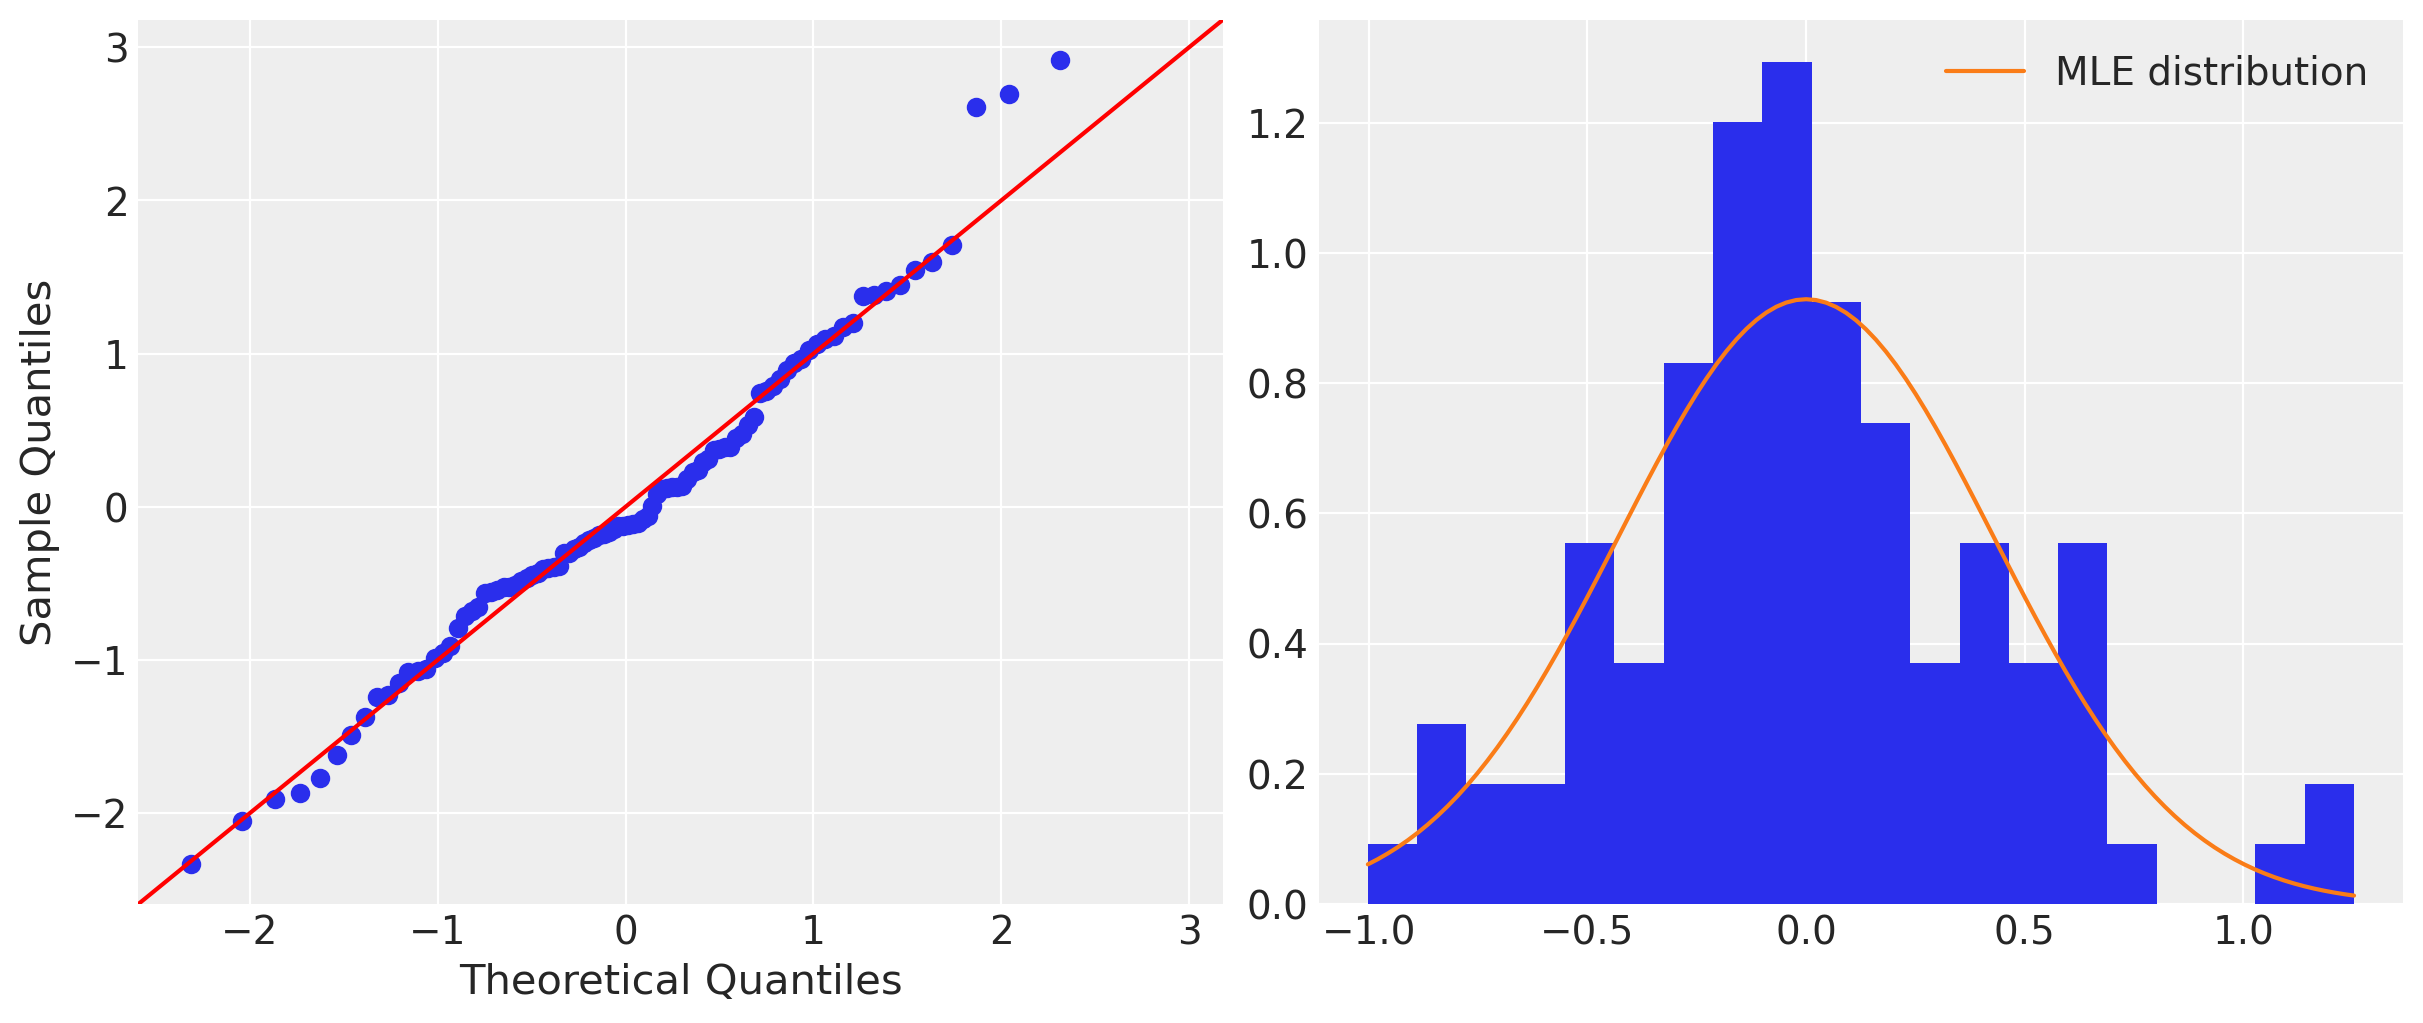

In [14]:
residuals = fit_split.resid
tt = np.linspace(np.min(residuals), np.max(residuals), 100)

# Test de Shapiro-Wilk
print(sp.stats.shapiro(residuals))

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
sm.qqplot(residuals, line = '45', fit = True, ax = axs[0]);
axs[1].hist(residuals, bins = 20, density = True);
axs[1].plot(tt, sp.stats.norm.pdf(tt, loc = residuals.mean(), scale = residuals.std()), label = "MLE distribution");
axs[1].legend();
plt.show()

#### Prédictions 

In [15]:
Yp_test = fit_split.predict(sm.add_constant(X_test, prepend=True))

#### Métriques d'évaluation des performances

In [16]:
# Calcul des RMSE
RMSE_train = np.sqrt(np.sum(fit_split.resid**2)/(X_train.shape[0]-X_train.shape[1]-1))
RMSE_test = np.sqrt(np.sum((Y_test-Yp_test)**2)/(X_test.shape[0]-X_test.shape[1]-1))

# Calcul des R-carré 
Rsquared_train = 1-np.sum(fit_split.resid**2)/np.sum((Y_train-Y_train.mean())**2)
Rsquared_test = 1-np.sum((Y_test-Yp_test)**2)/np.sum((Y_test-Y_test.mean())**2)

# Calcul des R-carré ajustés
Rsquaredadj_train = 1-(1-Rsquared_train)*(len(X_train)-1)/(len(X_train)-X_train.shape[1]-1)
Rsquaredadj_test = 1-(1-Rsquared_test)*(len(X_test)-1)/(len(X_test)-X_test.shape[1]-1)

# Tableau récapitulatif
df = np.array([[Rsquared_train, Rsquaredadj_train, RMSE_train], [Rsquared_test, Rsquaredadj_test, RMSE_test]])
df = pd.DataFrame(df, columns = [r"$R^2$", r"$R^2_{adj}$", "RMSE"], index = ["Train", "Test"])
df

$R^2$  $R^2_{adj}$      RMSE
Train  0.815870     0.803456  0.446073
Test   0.776343     0.697405  0.547222

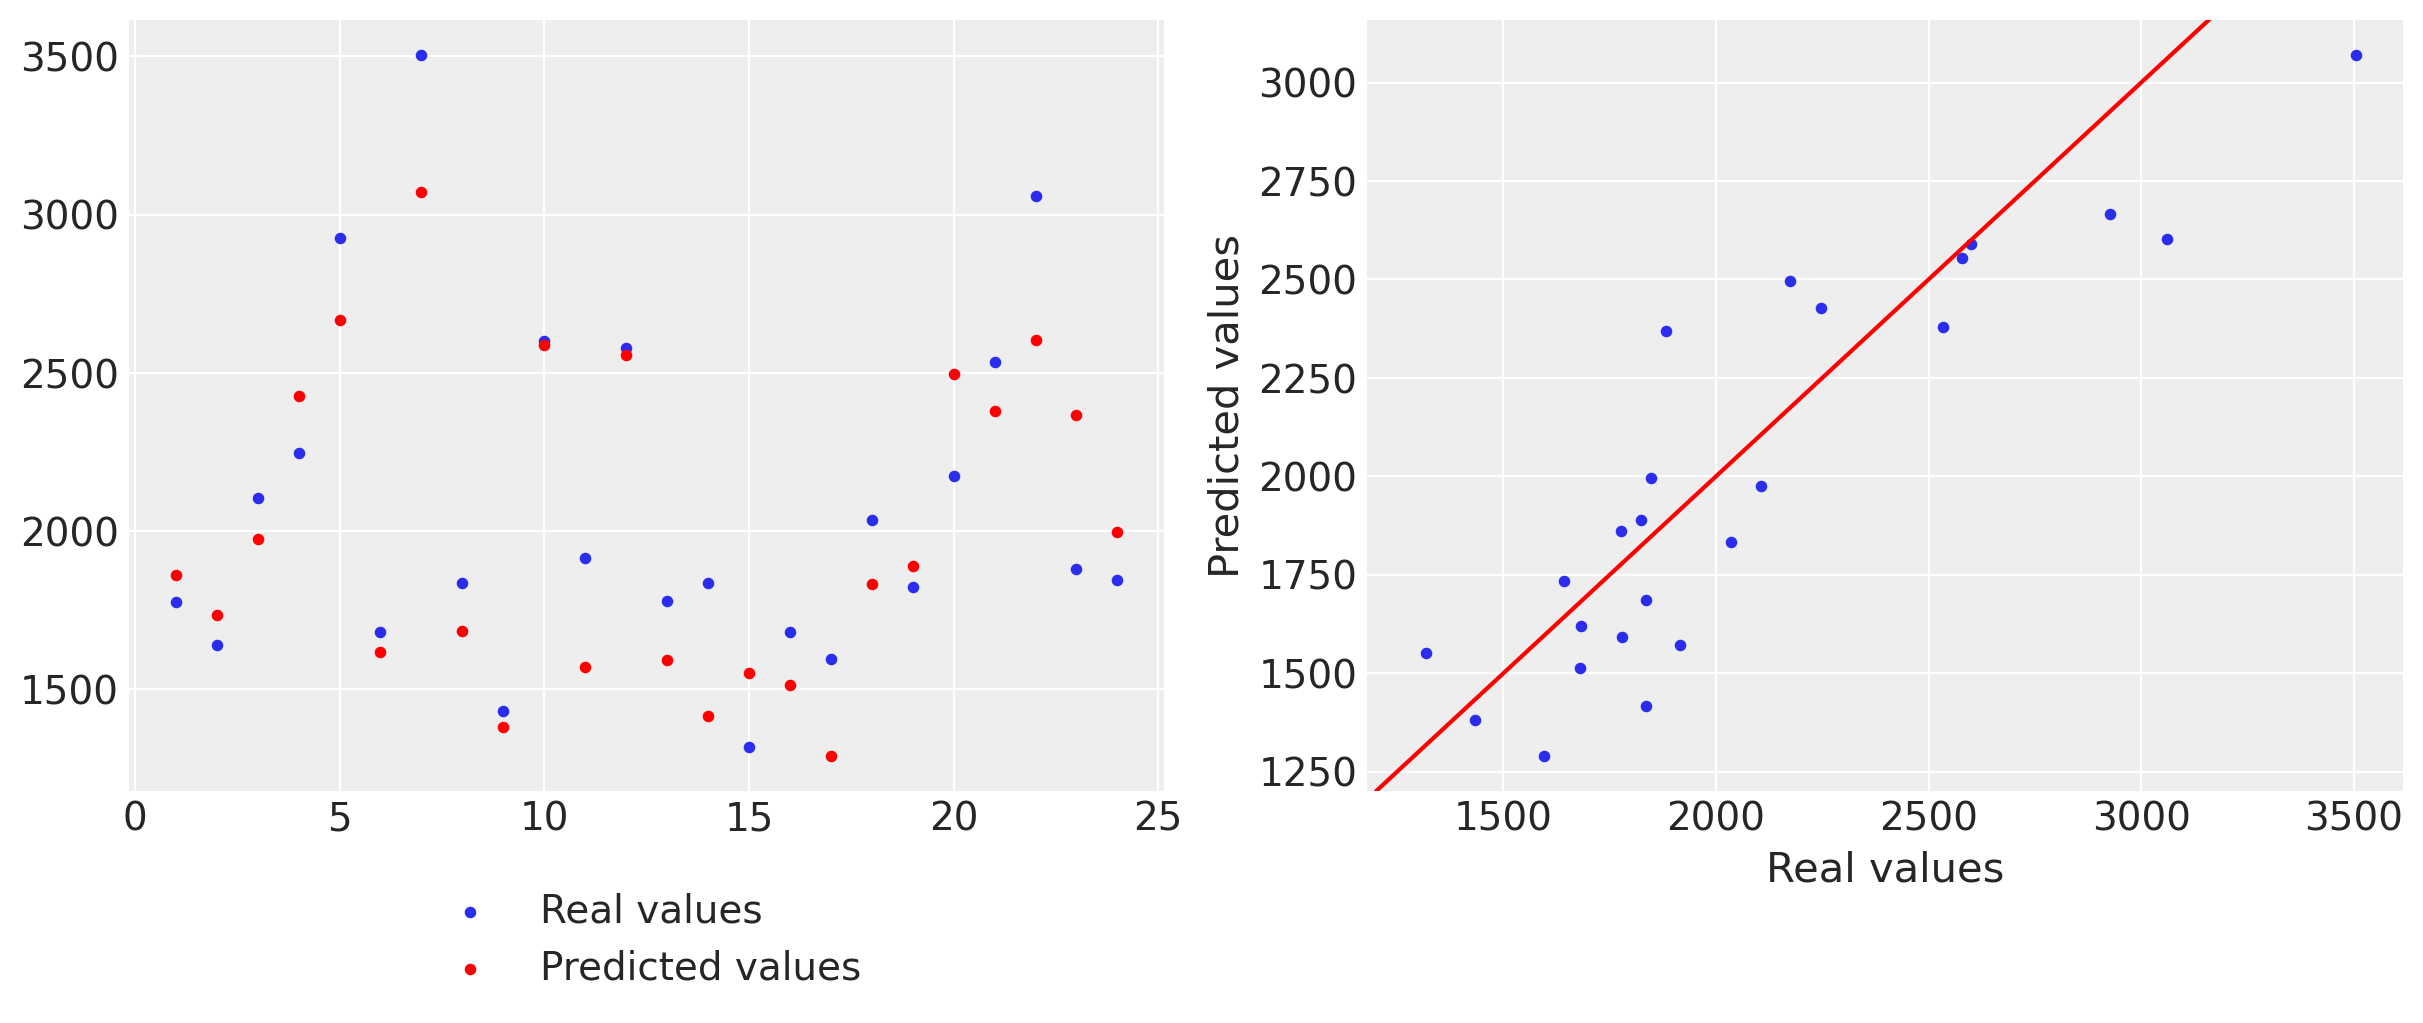

In [17]:
eta_pred = Yp_test*eta_sd+eta_mean
eta_real = Y_test*eta_sd+eta_mean
min = np.min(np.concatenate((eta_real, eta_pred)))

fig, axs = plt.subplots(1, 2, figsize = (12, 5))

axs[0].scatter(range(1, len(Y_test)+1), eta_real, label = "Real values", s = 10)
axs[0].scatter(range(1, len(Y_test)+1), eta_pred, label = "Predicted values", color = 'red', s = 10)
axs[0].legend(loc = "lower center", bbox_to_anchor = (0.5, -0.3))

axs[1].scatter(eta_real, eta_pred, s = 10)
axs[1].set_xlabel("Real values")
axs[1].set_ylabel("Predicted values")
axs[1].axline((min, min), slope=1, color = "red")

plt.show()

### Sur tout l'échantillon

In [18]:
# Définition du modèle et fit
mlr = sm.OLS(Y,  sm.add_constant(X, prepend=True))
fit = mlr.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     80.90
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           1.40e-38
Time:                        11:04:19   Log-Likelihood:                -69.756
No. Observations:                 120   AIC:                             153.5
Df Residuals:                     113   BIC:                             173.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0269      0.167      0.161      0.8

In [19]:
# Calcul des RMSE
RMSE = np.sqrt(np.sum(fit.resid**2)/(X.shape[0]-X.shape[1]-1))

# Calcul des R-carré 
Rsquared = 1-np.sum(fit.resid**2)/np.sum((Y-Y.mean())**2)

# Calcul des R-carré ajustés
Rsquaredadj = 1-(1-Rsquared_train)*(len(X)-1)/(len(X)-X.shape[1]-1)

# Tableau récapitulatif
df = np.array([[Rsquared, Rsquaredadj, RMSE]])
df = pd.DataFrame(df, columns = [r"$R^2$", r"$R^2_{adj}$", "RMSE"], index = ["All dataset"])
df

$R^2$  $R^2_{adj}$      RMSE
All dataset  0.811171     0.806093  0.445932

On obtient ici une valeur de $R^2$ de 0.811 et un $R^2_{adj}$ de 0.801 ce qui est acceptable, mais pourrait être meilleur. Le RMSE obtenu est très bon avec une valeur proche de 0. On voit de plus que le test de nullité pour le coefficient de régression de la variable $x_3$ n'est pas rejetté à 1%, ce qui signifie que cette variable n'a quasiment aucune influence sur le modèle, et l'enlever pourrait même légèrement améliorer celui-ci. Au vu de la valeur obtenue pour le coefficient d'assymétrie Skew, on peut donc s'attendre à ce que la queue droite de la distribution des résidus est moins aplatie que celle de gauche. 

#### Q-Q plot et histogramme des résidus

ShapiroResult(statistic=0.9906415949987848, pvalue=0.5927863481027782)


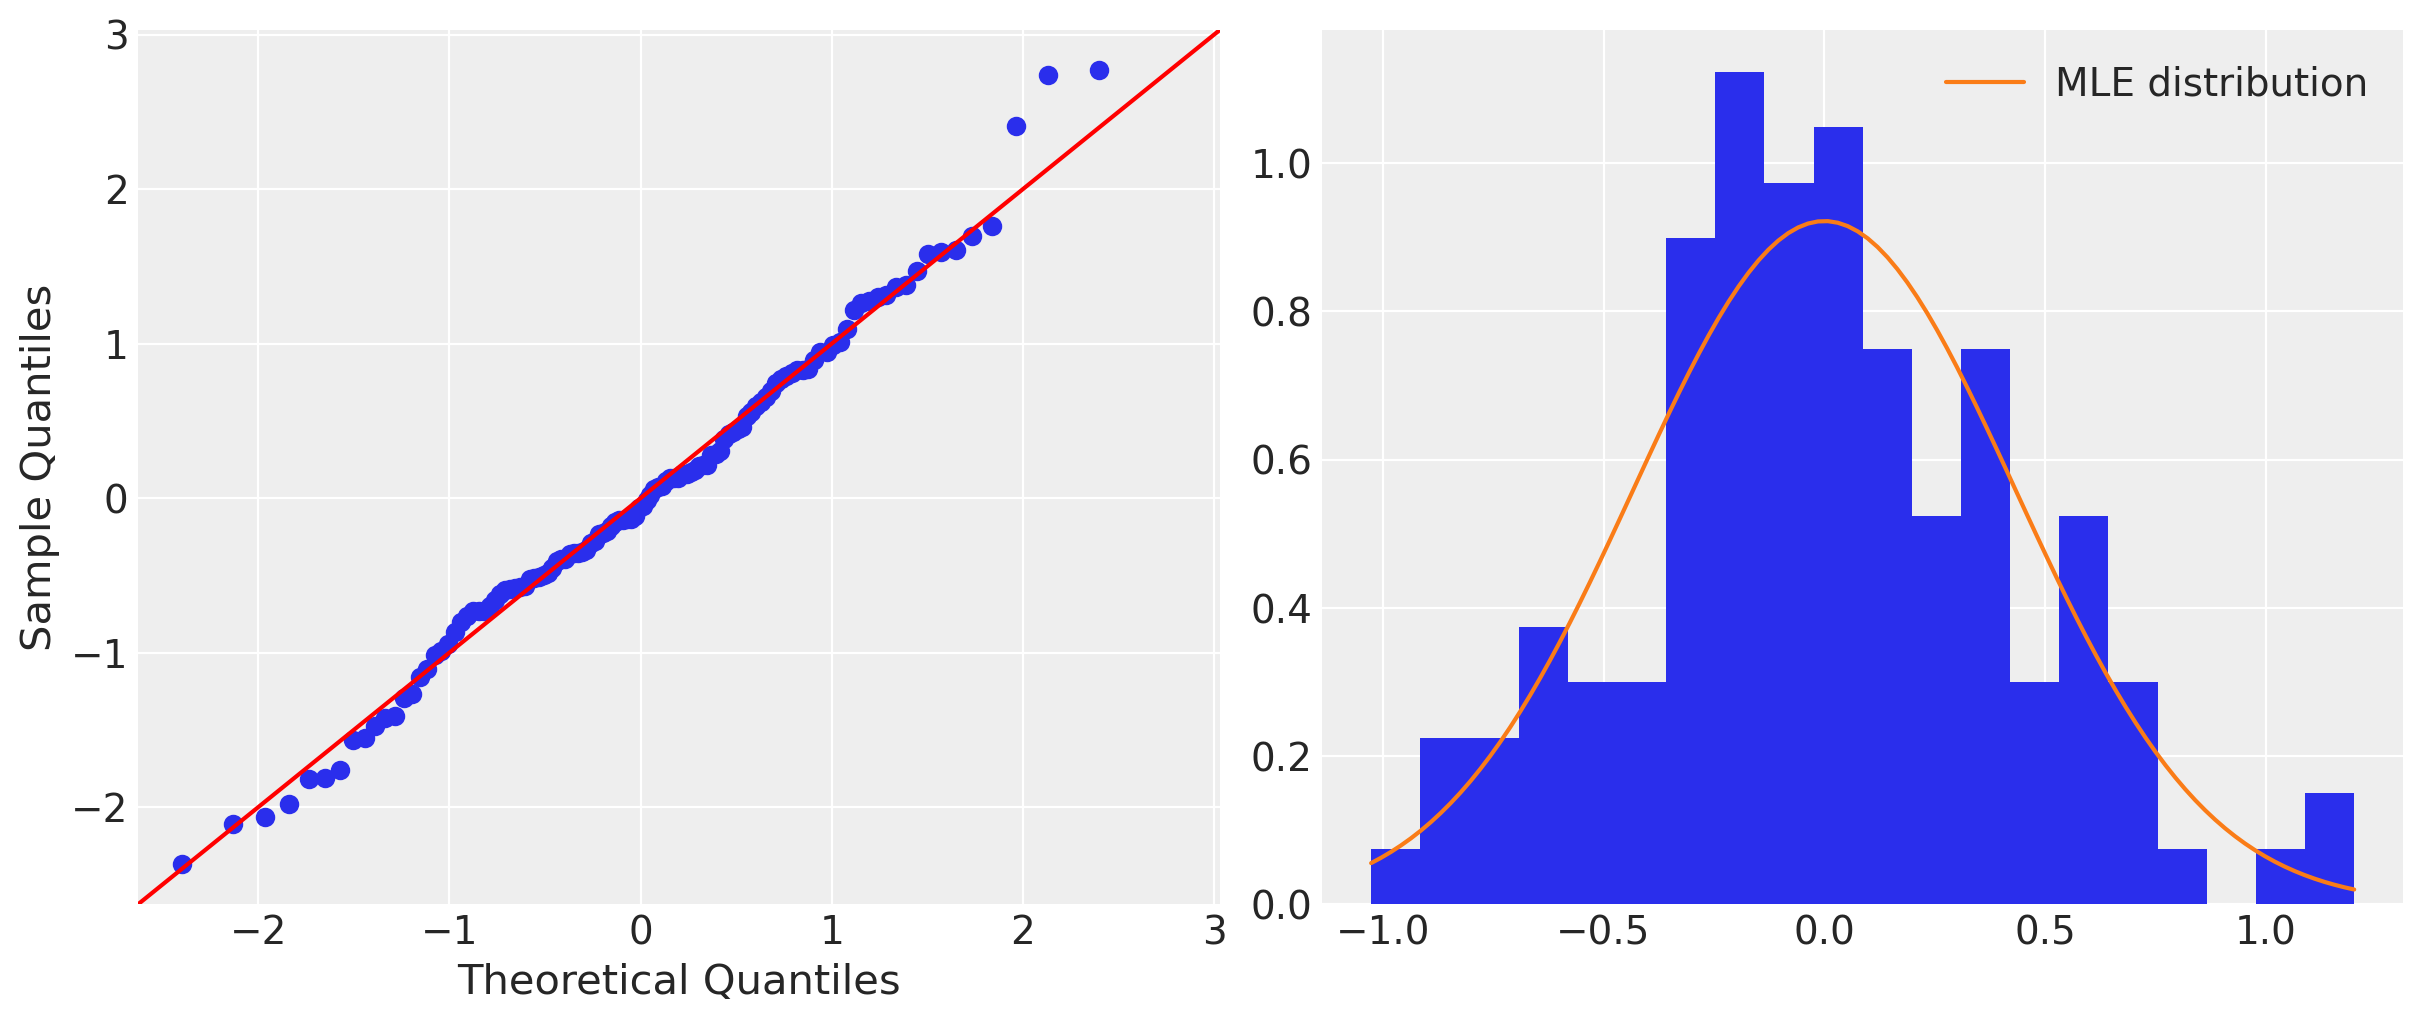

In [20]:
residuals = fit.resid
tt = np.linspace(np.min(residuals), np.max(residuals), 100)

# Test de Shapiro-Wilk
print(sp.stats.shapiro(residuals))

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
sm.qqplot(residuals, line = '45', fit = True, ax = axs[0]);
axs[1].hist(residuals, bins = 20, density = True);
axs[1].plot(tt, sp.stats.norm.pdf(tt, loc = residuals.mean(), scale = residuals.std()), label = "MLE distribution");
axs[1].legend();
plt.show()

Le QQ-plot nous permet de comparer les quantiles de nos résidus avec celui d'une loi normale, ici dont les paramètres correspondent au estimateurs du max de vraisemblance des résidus pour la loi normale. On voit que l'on a une bonne correspondance, bien qu'aux extremités, cela est bien moins le cas. On peut d'ailleurs visualiser cela vien un histogramme comme ci-dessous. Le test de Shapiro-Wilk permet ici de tester la normalité des résidus. On obtient une p-value de 0.59, on peut donc admettre que les résidus sont bien gaussiens.

#### Fitted VS Residuals

Sur cette histogramme, on retrouve bien le fait que la queue de distribution est plus importante à droite que celle de la loi normale que l'on teste.

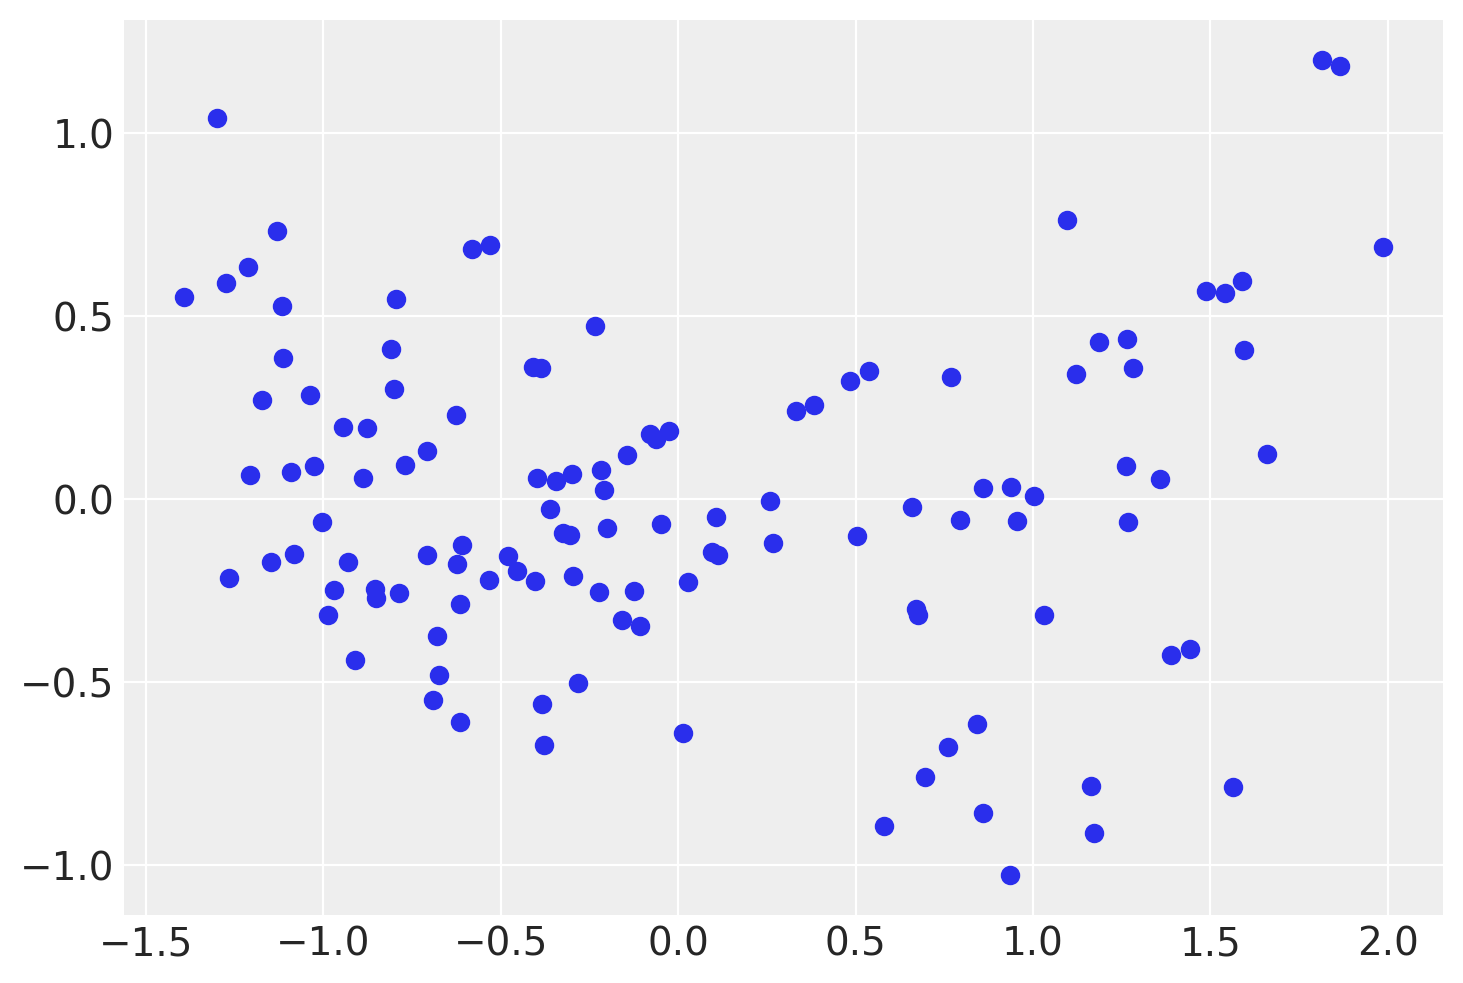

In [21]:
fitted = fit.fittedvalues
plt.scatter(fitted, residuals)

Le graphe Residuals VS Fitted ici montre une certaine tendance sur les résidus avec une variance qui semble augmenter pour les grandes valeurs des valeurs prédites. Cela montre encore une fois que le modèle peut être largement amélioré. Dans notre cas, on va tout de même appliquer la calibration bayésienne avec ce modèle.

#### Comparaison des prédictions avec les valeurs observées

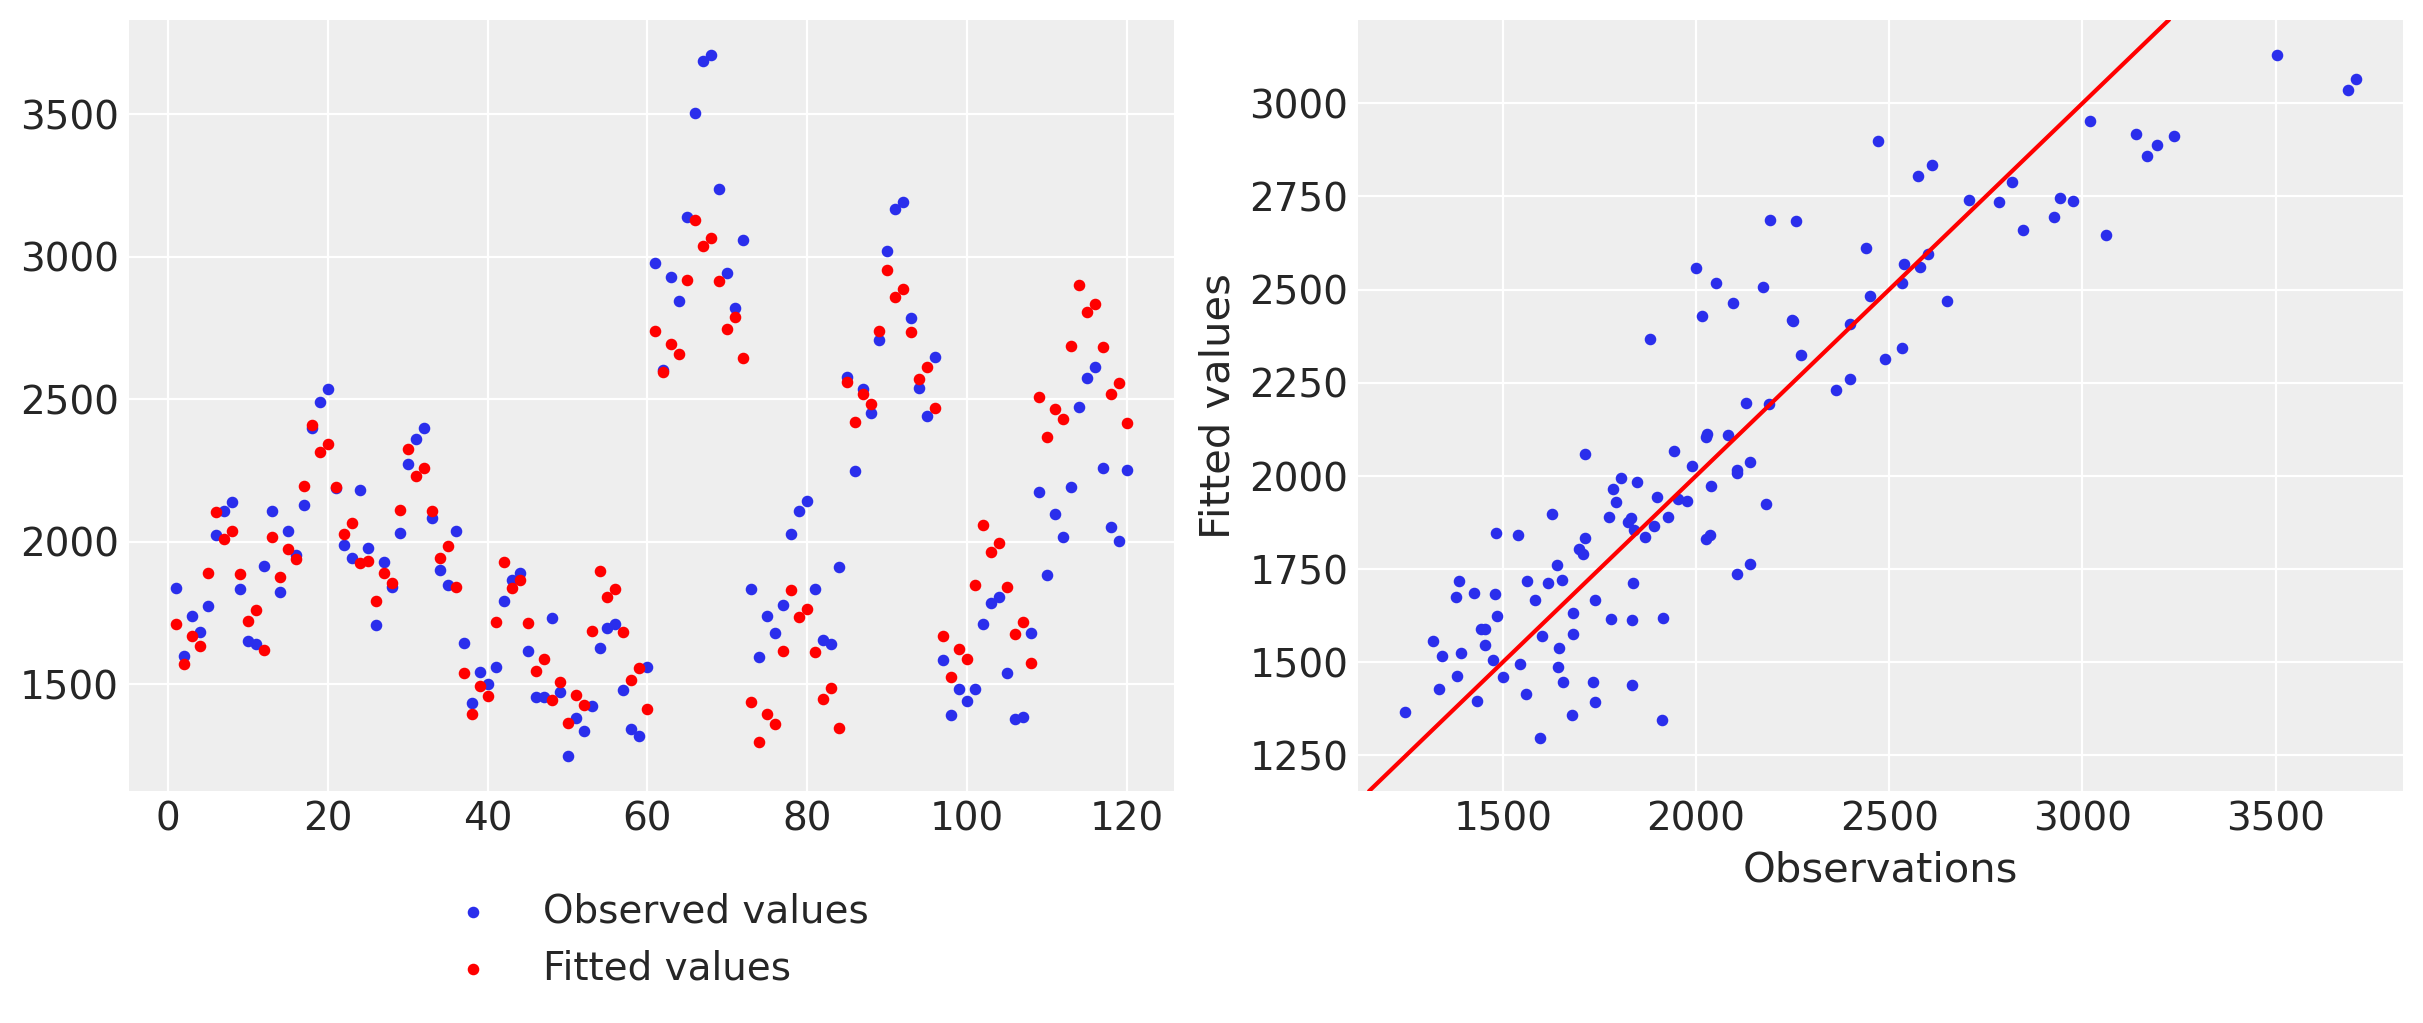

In [22]:
eta_pred = fitted*eta_sd+eta_mean
min = np.min(np.concatenate((eta.values, eta_pred)))

fig, axs = plt.subplots(1, 2, figsize = (12, 5))

axs[0].scatter(range(1,m+1), eta, label = "Observed values", s = 10)
axs[0].scatter(range(1, m+1), eta_pred, label = "Fitted values", color = 'red', s = 10)
axs[0].legend(loc = "lower center", bbox_to_anchor = (0.5, -0.3))

axs[1].scatter(eta, eta_pred, s = 10)
axs[1].set_xlabel("Observations")
axs[1].set_ylabel("Fitted values")
axs[1].axline((min, min), slope=1, color = "red")

plt.show()

On peut voir ici que le GP permet de faire de meilleures prédictions que MLR sur le même jeu de données.

### Modèle de calibration bayésienne avec MLR pour $\eta$

Le modèle complet est défini comme suit:

$$y(x,t)=\eta(x,t)+\delta(x)+\epsilon,$$

où $\epsilon\sim\mathcal{N}(0,\sigma^2)$, avec $\sigma>0$. On suppose que les $\epsilon_i$ sont identiquement et indépendemment distribués (i.i.d).

On suppose ici que seulement $\delta$ est un processus gaussien, i.e $\delta\sim GP(0,\Sigma_{\delta})$ dont la matrice de covaraince est définie comme suit;

$$\Sigma_{\delta,i,j}=K_{\delta}(x_{i},x_{j})=\frac{1}{\lambda_{\delta}}exp(-\sum_{k=1}^p \beta_k^{\delta}(x_{i}^k-x_{j}^k)^2),$$

où $x_{i}^k$ représente la $i$-ème observation du $k$-ème paramètre observable et $t_{i}^l$ représente la $i$-ème observation du $l$-ème paramètre incertain.

On peut donc déterminer la vraisemblance du modèle.

$$y\sim\mathcal{N}(\hat{\eta}, \Sigma_{\delta}+(\sigma^2+\sigma_{\eta}^2)I).$$

In [23]:
# Initialisation du modèle via PyMC
NI_model = pm.Model()

# Elaboration du modèle 
with NI_model:

    # Variables observées
    xf_obs = pm.Data("xf", xf_std)
   
    # Sorties observées
    y_obs = pm.Data("y_obs", y_std)

    # Coefficients de régression linéaire
    coefs = pm.Data("coefs", fit.params)

    # Ecart-type de l'erreur liée au modèle linéaire, ici RMSE
    sigma_eta = pm.Data("sigma_eta", RMSE)

    # Définition des priors pour les variables incertaines
    tf = pm.Uniform("tf", shape = q)

    # Concaténation des variables observées avec les variables incertaines
    tf_rep = pt.reshape(pt.tile(tf, n), newshape = (n, q))

    # Prédiction de MLR aux points (xf, tf)
    xtf = pt.concatenate((pt.ones((n, 1)), xf_obs, tf_rep), axis = 1)
    mlr_pred = pt.dot(xtf, coefs)

    # Covariance de eta
    cov_eta = pm.gp.cov.WhiteNoise(sigma_eta).full(xf_obs)
    
    # Définition des priors pour les hyperparamètres du GP de delta
    rho_delta = pm.Beta("rho_delta", alpha = 1, beta = 0.3, shape = p)
    lambda_delta = pm.Gamma("lambda_delta", alpha = 10, beta = 0.3)
    lambda_eps = pm.Gamma("lambda_eps", alpha = 10, beta = 0.03)
    
    # Transformation d'un hyperparamètre
    beta_delta = pm.Deterministic("beta_delta", -4.0*pt.log(rho_delta))

    # Matrice de covariance de delta
    cov_delta = 1/lambda_delta*pm.gp.cov.ExpQuad(p, ls = 1/pt.sqrt(2*beta_delta)).full(xf_obs)
    
    # Covariance des erreurs sur les observations
    sigma_eps = pt.sqrt(1/lambda_eps)
    cov_eps = pm.gp.cov.WhiteNoise(sigma_eps).full(xf_obs)

    # Covariance du modèle puis décomposition de Cholesky
    cov = cov_delta+cov_eps+cov_eta
    chol = cholesky(cov)

    # Vraisemblance des observations
    y_mod = pm.MvNormal("y_mod", mu = mlr_pred, chol = chol, observed = y_obs)

In [24]:
# Initialisation du modèle via PyMC
WI_model = pm.Model()

# Elaboration du modèle 
with WI_model:

    # Variables observées
    xf_obs = pm.Data("xf", xf_std)
    
    # Sorties observées
    y_obs = pm.Data("y_obs", y_std)

    # Coefficients de régression linéaire
    coefs = pm.Data("coefs", fit.params)

    # Ecart-type de l'erreur liée au modèle linéaire, ici RMSE
    sigma_eta = pm.Data("sigma_eta", RMSE)

    # Définition des priors pour les variables incertaines
    tf = pm.Truncated("tf", pm.Normal.dist(mu = [0.5, 0.7, 0.14], sigma = 0.2), lower = 0.0, upper = 1.0)

    # Concaténation des variables observées avec les variables incertaines
    tf_rep = pt.reshape(pt.tile(tf, n), newshape = (n, q))

    # Prédiction de MLR aux points (xf, tf)
    xtf = pt.concatenate((pt.ones((n, 1)), xf_obs, tf_rep), axis = 1)
    mlr_pred = pt.dot(xtf, coefs)

    # Covariance de eta
    cov_eta = pm.gp.cov.WhiteNoise(sigma_eta).full(xf_obs)
    
    # Définition des priors pour les hyperparamètres du GP de delta
    rho_delta = pm.Beta("rho_delta", alpha = 1, beta = 0.3, shape = p)
    lambda_delta = pm.Gamma("lambda_delta", alpha = 10, beta = 0.3)
    lambda_eps = pm.Gamma("lambda_eps", alpha = 10, beta = 0.03)
    
    # Transformation d'un hyperparamètre
    beta_delta = pm.Deterministic("beta_delta", -4.0*pt.log(rho_delta))

    # Matrice de covariance de delta
    cov_delta = 1/lambda_delta*pm.gp.cov.ExpQuad(p, ls = 1/pt.sqrt(2*beta_delta)).full(xf_obs)
    
    # Covariance des erreurs sur les observations
    sigma_eps = pt.sqrt(1/lambda_eps)
    cov_eps = pm.gp.cov.WhiteNoise(sigma_eps).full(xf_obs)

    # Covariance du modèle puis décomposition de Cholesky
    cov = cov_delta+cov_eps+cov_eta
    chol = cholesky(cov)

    # Vraisemblance des observations
    y_mod = pm.MvNormal("y_mod", mu = mlr_pred, chol = chol, observed = y_obs)

In [25]:
# Initialisation du modèle via PyMC
SI_model = pm.Model()

# Elaboration du modèle 
with SI_model:

    # Variables observées
    xf_obs = pm.Data("xf", xf_std)
    
    # Sorties observées
    y_obs = pm.Data("y_obs", y_std)

    # Coefficients de régression linéaire
    coefs = pm.Data("coefs", fit.params)

    # Ecart-type de l'erreur liée au modèle linéaire, ici RMSE
    sigma_eta = pm.Data("sigma_eta", RMSE)

    # Définition des priors pour les variables incertaines
    tf = pm.Truncated("tf", pm.Normal.dist(mu = [0.5, 0.7, 0.14], sigma = 0.05), lower = 0.0, upper = 1.0)

    # Concaténation des variables observées avec les variables incertaines
    tf_rep = pt.reshape(pt.tile(tf, n), newshape = (n, q))

    # Prédiction de MLR aux points (xf, tf)
    xtf = pt.concatenate((pt.ones((n, 1)), xf_obs, tf_rep), axis = 1)
    mlr_pred = pt.dot(xtf, coefs)

    # Covariance de eta
    cov_eta = pm.gp.cov.WhiteNoise(sigma_eta).full(xf_obs)
    
    # Définition des priors pour les hyperparamètres du GP de delta
    rho_delta = pm.Beta("rho_delta", alpha = 1, beta = 0.3, shape = p)
    lambda_delta = pm.Gamma("lambda_delta", alpha = 10, beta = 0.3)
    lambda_eps = pm.Gamma("lambda_eps", alpha = 10, beta = 0.03)
    
    # Transformation d'un hyperparamètre
    beta_delta = pm.Deterministic("beta_delta", -4.0*pt.log(rho_delta))

    # Matrice de covariance de delta
    cov_delta = 1/lambda_delta*pm.gp.cov.ExpQuad(p, ls = 1/pt.sqrt(2*beta_delta)).full(xf_obs)
    
    # Covariance des erreurs sur les observations
    sigma_eps = pt.sqrt(1/lambda_eps)
    cov_eps = pm.gp.cov.WhiteNoise(sigma_eps).full(xf_obs)

    # Covariance du modèle puis décomposition de Cholesky
    cov = cov_delta+cov_eps+cov_eta
    chol = cholesky(cov)

    # Vraisemblance des observations
    y_mod = pm.MvNormal("y_mod", mu = mlr_pred, chol = chol, observed = y_obs)

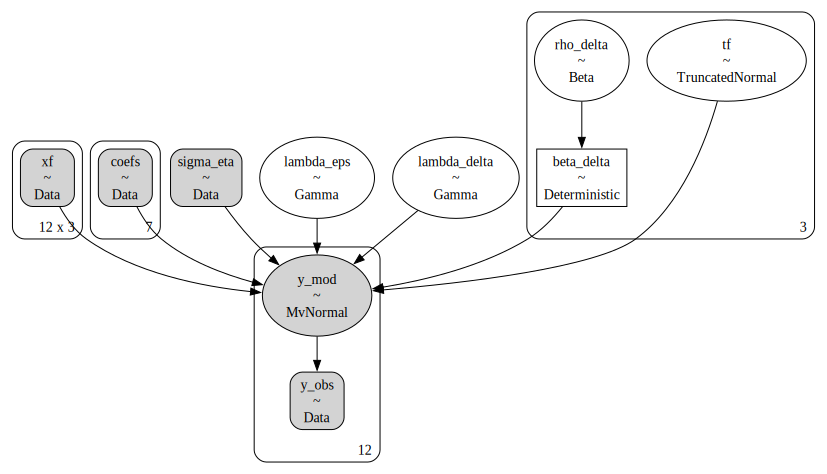

In [26]:
pm.model_to_graphviz(WI_model)

In [27]:
# Burn-in et taille posteriors
n_tune = 5000
n_draws = 1000
chains = 4
cores = 4

In [28]:
with NI_model:
    idataNI = pm.sample(draws = n_draws, tune = n_tune, random_seed = rng, chains = chains, cores = cores, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tf, rho_delta, lambda_delta, lambda_eps]


Output()

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 147 seconds.


In [29]:
with WI_model:
    idataWI = pm.sample(draws = n_draws, tune = n_tune, random_seed = rng, chains = chains, cores = cores, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tf, rho_delta, lambda_delta, lambda_eps]


Output()

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 101 seconds.


In [30]:
with SI_model:
    idataSI = pm.sample(draws = n_draws, tune = n_tune, random_seed = rng, chains = chains, cores = cores, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tf, rho_delta, lambda_delta, lambda_eps]


Output()

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 76 seconds.


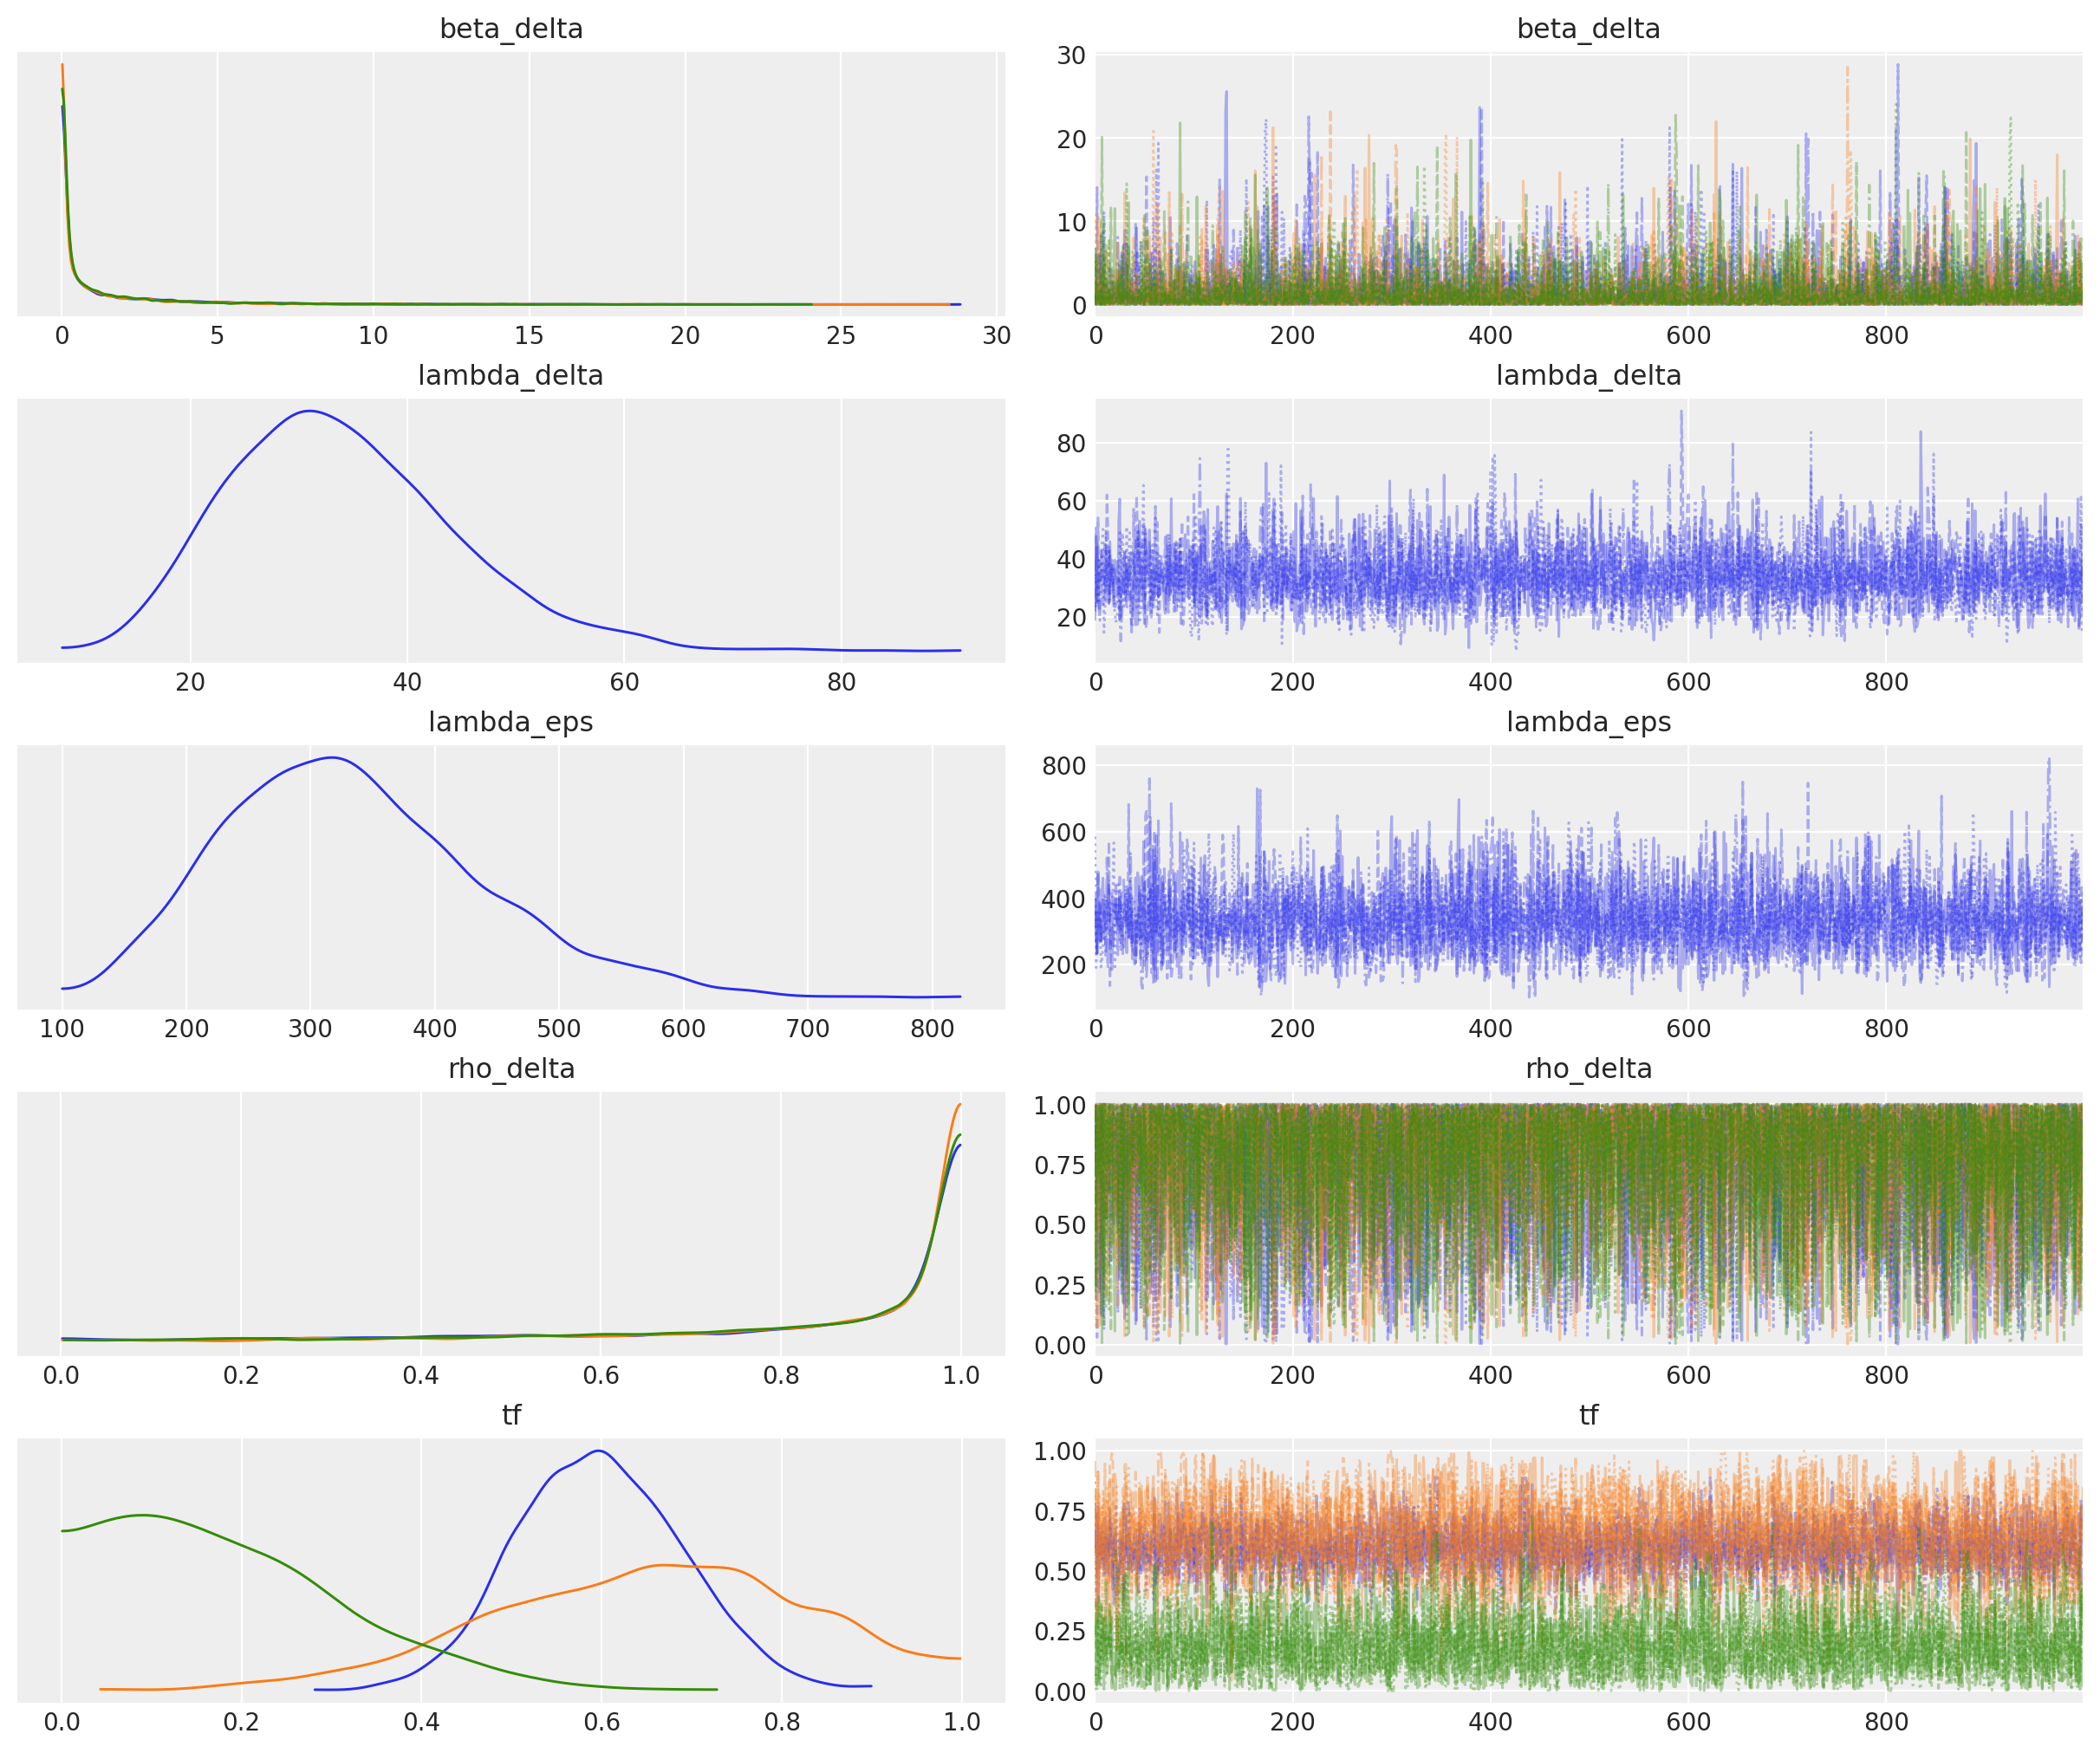

In [31]:
# Affichage des distributions à posteriori et des chaines de Markov pour chaque paramètre
az.plot_trace(idataWI, combined = True, compact = True);

In [32]:
az.summary(idataNI)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_delta[0]    1.516    2.758    0.000    6.360      0.050    0.039   
beta_delta[1]    1.475    2.719    0.000    6.434      0.045    0.033   
beta_delta[2]    1.468    2.670    0.000    5.994      0.045    0.034   
lambda_delta    33.768   10.585   14.968   53.148      0.166    0.118   
lambda_eps     334.266  103.835  147.147  526.765      1.778    1.258   
rho_delta[0]     0.783    0.271    0.204    1.000      0.004    0.003   
rho_delta[1]     0.790    0.270    0.200    1.000      0.004    0.003   
rho_delta[2]     0.787    0.266    0.223    1.000      0.004    0.003   
tf[0]            0.687    0.166    0.417    0.997      0.003    0.002   
tf[1]            0.474    0.285    0.001    0.930      0.005    0.004   
tf[2]            0.471    0.277    0.000    0.916      0.006    0.005   

               ess_bulk  ess_tail  r_hat  
beta_delta[0]    2288.0    1360.0    1.0  
beta_delta[1]    2350.0    1290.0    1.0  
beta_delta[2]    2437.0    1454.0    1.0  
lambda_delta     3832.0    2517.0    1.0  
lambda_eps       3279.0    2452.0    1.0  
rho_delta[0]     2288.0    1360.0    1.0  
rho_delta[1]     2350.0    1290.0    1.0  
rho_delta[2]     2437.0    1454.0    1.0  
tf[0]            2296.0    1755.0    1.0  
tf[1]            3089.0    2324.0    1.0  
tf[2]            2150.0    2368.0    1.0

In [33]:
az.summary(idataWI)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_delta[0]    1.567    2.844    0.000    6.423      0.052    0.042   
beta_delta[1]    1.358    2.580    0.000    5.527      0.041    0.032   
beta_delta[2]    1.461    2.616    0.000    6.210      0.041    0.033   
lambda_delta    33.928   10.508   15.344   53.274      0.165    0.118   
lambda_eps     334.677  104.817  148.028  531.610      1.545    1.117   
rho_delta[0]     0.778    0.274    0.201    1.000      0.004    0.003   
rho_delta[1]     0.801    0.258    0.251    1.000      0.004    0.003   
rho_delta[2]     0.786    0.265    0.212    1.000      0.004    0.003   
tf[0]            0.598    0.092    0.428    0.771      0.002    0.001   
tf[1]            0.650    0.173    0.360    0.987      0.003    0.002   
tf[2]            0.188    0.130    0.000    0.421      0.002    0.002   

               ess_bulk  ess_tail  r_hat  
beta_delta[0]    3367.0    1764.0    1.0  
beta_delta[1]    2960.0    1752.0    1.0  
beta_delta[2]    2851.0    1504.0    1.0  
lambda_delta     3905.0    2684.0    1.0  
lambda_eps       4384.0    2353.0    1.0  
rho_delta[0]     3367.0    1764.0    1.0  
rho_delta[1]     2960.0    1752.0    1.0  
rho_delta[2]     2851.0    1504.0    1.0  
tf[0]            3208.0    2481.0    1.0  
tf[1]            3743.0    1874.0    1.0  
tf[2]            3305.0    2203.0    1.0

In [34]:
az.summary(idataSI)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_delta[0]    1.515    2.692    0.000    6.558      0.039    0.031   
beta_delta[1]    1.365    2.649    0.000    5.431      0.043    0.034   
beta_delta[2]    1.459    2.643    0.000    6.006      0.039    0.032   
lambda_delta    33.546   10.753   15.612   54.435      0.156    0.111   
lambda_eps     335.075  104.971  150.982  529.639      1.530    1.082   
rho_delta[0]     0.783    0.275    0.194    1.000      0.004    0.003   
rho_delta[1]     0.801    0.258    0.257    1.000      0.004    0.003   
rho_delta[2]     0.787    0.265    0.223    1.000      0.003    0.002   
tf[0]            0.544    0.037    0.477    0.615      0.001    0.000   
tf[1]            0.687    0.049    0.596    0.777      0.001    0.001   
tf[2]            0.117    0.047    0.031    0.206      0.001    0.001   

               ess_bulk  ess_tail  r_hat  
beta_delta[0]    4030.0    1927.0    1.0  
beta_delta[1]    2700.0    1329.0    1.0  
beta_delta[2]    3502.0    1711.0    1.0  
lambda_delta     4461.0    2835.0    1.0  
lambda_eps       4304.0    2405.0    1.0  
rho_delta[0]     4030.0    1927.0    1.0  
rho_delta[1]     2700.0    1329.0    1.0  
rho_delta[2]     3502.0    1711.0    1.0  
tf[0]            3824.0    3068.0    1.0  
tf[1]            3942.0    2520.0    1.0  
tf[2]            2006.0     935.0    1.0

In [35]:
tf_std_NI = pd.DataFrame(az.extract(idataNI, group = 'posterior', combined = True, var_names = "tf").T, columns = [f"tc{i}" for i in range(1, q+1)])
tf_std_WI = pd.DataFrame(az.extract(idataWI, group = 'posterior', combined = True, var_names = "tf").T, columns = [f"tc{i}" for i in range(1, q+1)])
tf_std_SI = pd.DataFrame(az.extract(idataSI, group = 'posterior', combined = True, var_names = "tf").T, columns = [f"tc{i}" for i in range(1, q+1)])

In [36]:
tf_NI = tf_std_NI*(tc_max-tc_min)+tc_min
tf_WI = tf_std_WI*(tc_max-tc_min)+tc_min
tf_SI = tf_std_SI*(tc_max-tc_min)+tc_min

In [37]:
n_points = 100

a = [tc_max.iloc[0]-tc_min.iloc[0], tc_max.iloc[1]-tc_min.iloc[1], tc_max.iloc[2]-tc_min.iloc[2]]
b = [tc_min.iloc[0], tc_min.iloc[1], tc_min.iloc[2]]

tt1 = np.linspace(tc_min.iloc[0], tc_max.iloc[0], n_points)
tt2 = np.linspace(tc_min.iloc[1], tc_max.iloc[1], n_points)
tt3 = np.linspace(tc_min.iloc[2], tc_max.iloc[2], n_points)

pdf_NI = np.zeros((3, n_points))
pdf_WI = np.zeros((3, n_points))
pdf_SI = np.zeros((3, n_points))

pdf_NI[0,:] = sp.stats.uniform.pdf(tt1, loc = b[0], scale = a[0])
pdf_NI[1,:] = sp.stats.uniform.pdf(tt2, loc = b[1], scale = a[1])
pdf_NI[2,:] = sp.stats.uniform.pdf(tt3, loc = b[2], scale = a[2])

pdf_SI[0,:] = sp.stats.norm.pdf(tt1, loc = a[0]*0.5+b[0], scale = 0.05*a[0])
pdf_SI[1,:] = sp.stats.norm.pdf(tt2, loc = a[1]*0.7+b[1], scale = 0.05*a[1])
pdf_SI[2,:] = sp.stats.norm.pdf(tt3, loc = a[2]*0.14+b[2], scale = 0.05*a[2])
        
pdf_WI[0,:] = sp.stats.norm.pdf(tt1, loc = a[0]*0.5+b[0], scale = 0.2*a[0])
pdf_WI[1,:] = sp.stats.norm.pdf(tt2, loc = a[1]*0.7+b[1], scale = 0.2*a[1])
pdf_WI[2,:] = sp.stats.norm.pdf(tt3, loc = a[2]*0.14+b[2], scale = 0.2*a[2])

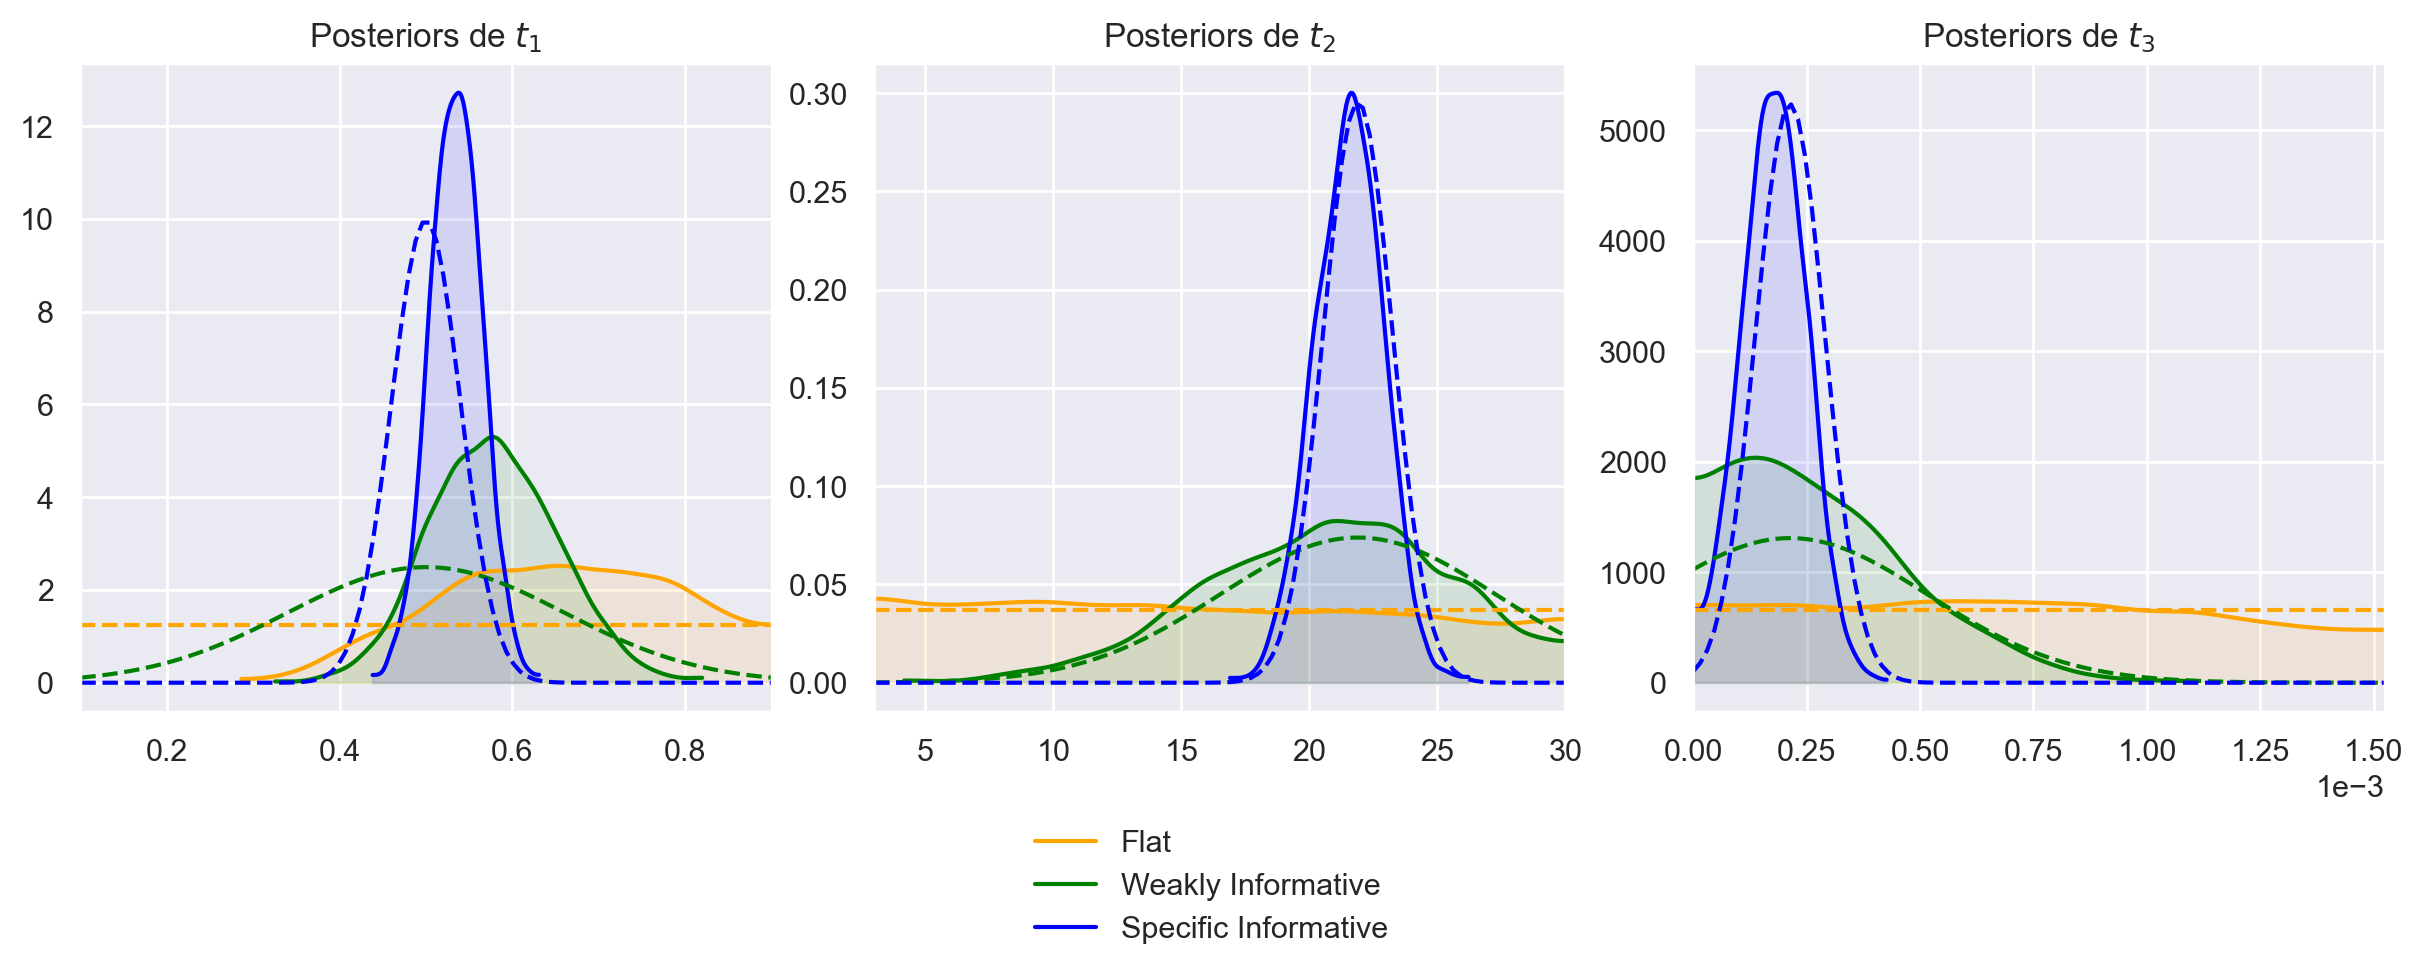

In [38]:
sns.set()

tc1_NI, dtc1_NI = az.kde(tf_NI["tc1"])
tc2_NI, dtc2_NI = az.kde(tf_NI["tc2"])
tc3_NI, dtc3_NI = az.kde(tf_NI["tc3"])

tc1_WI, dtc1_WI = az.kde(tf_WI["tc1"])
tc2_WI, dtc2_WI = az.kde(tf_WI["tc2"])
tc3_WI, dtc3_WI = az.kde(tf_WI["tc3"])

tc1_SI, dtc1_SI = az.kde(tf_SI["tc1"])
tc2_SI, dtc2_SI = az.kde(tf_SI["tc2"])
tc3_SI, dtc3_SI = az.kde(tf_SI["tc3"])

labels = ["Flat", "Weakly Informative", "Specific Informative"]

# Tracé des distributions à posteriori
fig, axs = plt.subplots(1, 3, figsize = (12,4))


axs[0].plot(tc1_NI, dtc1_NI, color = "orange", label = labels[0]);
axs[0].plot(tc1_WI, dtc1_WI, color = "green", label = labels[1]);
axs[0].plot(tc1_SI, dtc1_SI, color = "blue", label = labels[2]);
axs[0].plot(tt1, pdf_NI[0], color = "orange", linestyle = "dashed");
axs[0].plot(tt1, pdf_WI[0], color = "green", linestyle = "dashed");
axs[0].plot(tt1, pdf_SI[0], color = "blue", linestyle = "dashed");
axs[0].fill_between(tc1_NI, dtc1_NI, 0, color = 'orange', alpha= 0.1);
axs[0].fill_between(tc1_WI, dtc1_WI, 0, color = 'green', alpha= 0.1);
axs[0].fill_between(tc1_SI, dtc1_SI, 0, color = 'blue', alpha= 0.1);
axs[0].set_xlim(tc_min.iloc[0], tc_max.iloc[0]);
axs[0].set_title(r"Posteriors de $t_1$");

axs[1].plot(tc2_NI, dtc2_NI, color = "orange", label = labels[0]);
axs[1].plot(tc2_WI, dtc2_WI, color = "green", label = labels[1]);
axs[1].plot(tc2_SI, dtc2_SI, color = "blue", label = labels[2]);
axs[1].plot(tt2, pdf_NI[1], color = "orange", linestyle = "dashed");
axs[1].plot(tt2, pdf_WI[1], color = "green", linestyle = "dashed");
axs[1].plot(tt2, pdf_SI[1], color = "blue", linestyle = "dashed");
axs[1].fill_between(tc2_NI, dtc2_NI, 0, color = 'orange', alpha= 0.1);
axs[1].fill_between(tc2_WI, dtc2_WI, 0, color = 'green', alpha= 0.1);
axs[1].fill_between(tc2_SI, dtc2_SI, 0, color = 'blue', alpha= 0.1);
axs[1].set_xlim(tc_min.iloc[1], tc_max.iloc[1]);
axs[1].set_title(r"Posteriors de $t_2$");

axs[2].plot(tc3_NI, dtc3_NI, color = "orange", label = labels[0]);
axs[2].plot(tc3_WI, dtc3_WI, color = "green", label = labels[1]);
axs[2].plot(tc3_SI, dtc3_SI, color = "blue", label = labels[2]);
axs[2].plot(tt3, pdf_NI[2], color = "orange", linestyle = "dashed");
axs[2].plot(tt3, pdf_WI[2], color = "green", linestyle = "dashed");
axs[2].plot(tt3, pdf_SI[2], color = "blue", linestyle = "dashed");
axs[2].fill_between(tc3_NI, dtc3_NI, 0, color = 'orange', alpha= 0.1);
axs[2].fill_between(tc3_WI, dtc3_WI, 0, color = 'green', alpha= 0.1);
axs[2].fill_between(tc3_SI, dtc3_SI, 0, color = 'blue', alpha= 0.1);
axs[2].set_xlim(tc_min.iloc[2], tc_max.iloc[2]);
axs[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs[2].set_title(r"Posteriors de $t_3$");

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.2));

## Prédictions du modèle à posteriori

On note $y^*$ les valeurs que l'on souhaite prédire aux points $x^*$. Dans ce qui suit, on note $u=(x,t)$ l'ensemble des paramètres du modèle, puis on fait la distinction entre $u_f$ et $u^*$ qui correspondent resepctivement à $(x_f, t_f)$, et enfin $(x^*, t_f)$. On note de plus $f(u)$ et $f(u^*)$ les prédictions de MLR respectivement aux points $u$ et $u^*$. La loi jointe de $y$ et $y^*$ peut donc s'écrire:

$$\begin{bmatrix} y \\ y^* \end{bmatrix} \sim\mathcal{N}\biggl(\begin{bmatrix} f(u) \\ f(u^*) \end{bmatrix}, \begin{bmatrix} K_{\delta}(x_f,x_f)+(\sigma^2+\sigma_{\eta}^2)I & K_{\delta}(x_f,x^*) \\ K_{\delta}(x^*,x_f) & K_{\delta}(x^*,x^*)+(\sigma^2+\sigma_{\eta}^2)I \end{bmatrix}\biggr)$$

Les hypothèses d'indépendances entre $\eta$, $\delta$ et $\epsilon$ sont nécessaires pour obtenir la loi jointe ci-dessus.
Afin de faire la prédiction de $y^*$, il faut donc prendre la conditionnel de $y^*$ sachant $y$. Dans ce qui suit, on note $\Sigma_y$ la matrice de covariance de $y$ définie comme suit:

$$\Sigma_y=\begin{bmatrix}K_{\delta}(x_f,x_f)+(\sigma^2+\sigma_{\eta}^2)I\end{bmatrix}$$

On a ainsi,

$$ y^*|y \sim\mathcal{N}(\mu^*, \Sigma^*),$$

avec

$$\mu^*= f(u^*)+\begin{bmatrix}K_{\delta}(x^*,x_f)\end{bmatrix} \Sigma_y^{-1}(y-f(u)),$$

$$\Sigma^*= \begin{bmatrix}K_{\delta}(x^*,x^*)+(\sigma^2+\sigma_{\eta}^2)I \end{bmatrix}-\begin{bmatrix}K_{\delta}(x^*,x_f)\end{bmatrix}\Sigma_y^{-1}\begin{bmatrix}K_{\delta}(x_f,x^*)\end{bmatrix}.$$

La loi jointe de $y$ et $\eta^*+\delta^*+\epsilon_{\eta}$ s'écrit:

$$\begin{bmatrix} y \\ \eta^*+\delta^*+\epsilon_{\eta} \end{bmatrix} \sim\mathcal{N}\biggl(\begin{bmatrix} f(u) \\ f(u^*) \end{bmatrix}, \begin{bmatrix} K_{\delta}(x_f,x_f)+(\sigma^2+\sigma_{\eta}^2)I & K_{\delta}(x_f,x^*) \\ K_{\delta}(x^*,x_f) & K_{\delta}(x^*,x^*)+\sigma_{\eta}^2I \end{bmatrix}\biggr)$$

On a ainsi,

$$ \eta^*+\delta^*+\epsilon_{\eta}|y \sim\mathcal{N}(\mu^*, \Sigma^*),$$

avec

$$\mu^*= f(u^*)+\begin{bmatrix}K_{\delta}(x^*,x_f)\end{bmatrix} \Sigma_y^{-1}(y-f(u)),$$

$$\Sigma^*= \begin{bmatrix}K_{\delta}(x^*,x^*)+\sigma_{\eta}^2I \end{bmatrix}-\begin{bmatrix}K_{\delta}(x^*,x_f)\end{bmatrix}\Sigma_y^{-1}\begin{bmatrix}K_{\delta}(x_f,x^*)\end{bmatrix}.$$

La loi jointe de $y$ et $\eta^*+\epsilon_{\eta}$ s'écrit:

$$\begin{bmatrix} y \\ \eta^*+\epsilon_{\eta} \end{bmatrix} \sim\mathcal{N}\biggl(\begin{bmatrix} f(u) \\ f(u^*) \end{bmatrix}, \begin{bmatrix} K_{\delta}(x_f,x_f)+(\sigma^2+\sigma_{\eta}^2)I & 0 \\ 0 & \sigma_{\eta}^2I \end{bmatrix}\biggr)$$

On a ainsi,

$$ \eta^*+\epsilon_{\eta}|y\sim\mathcal{N}(\mu^*, \Sigma^*),$$

avec

$$\mu^*= f(u^*),$$

$$\Sigma^*= \sigma_{\eta}^2I .$$

Enfin, pour obtenir la prédiction de $\delta^*$ conditionnellement à $y$, soit le même raisonnement peut être appliqué pour la calculer, soit on fait la différence entre $\eta^*+\delta^+\epsilon_{\eta}*$ et $\eta^*+\epsilon_{\eta}$.

In [39]:
# Fonction permettant d'extraire les posteriors pour chaque paramètres et hyper-paramètres 
def extract_idata(idata):

    # Extraction des posteriors
    tf = az.extract(idata, var_names = ["tf"], combined = True).values.T
    beta_delta = az.extract(idata, var_names = ["beta_delta"], combined = True).values.T
    lambda_delta = az.extract(idata, var_names = ["lambda_delta"], combined = True).values.reshape((n_draws*chains))
    lambda_eps = az.extract(idata, var_names = ["lambda_eps"], combined = True).values.reshape((n_draws*chains))

    n = len(tf)
    posteriors = []

    for i in range(n):
        posteriors.append({"tf": tf[i], "beta_delta": beta_delta[i], "lambda_delta": lambda_delta[i], "lambda_eps": lambda_eps[i]})
                          
    return posteriors

### Fonctions permettant les prédictions

In [40]:
partial_eta_delta_pred = partial(PredictionsMLR.eta_delta_pred, coefs = fit.params, sigma_eta = RMSE, x_star = np.array(x_star_std), 
                             xf = np.array(xf_std), y = y_std)

partial_eta_pred = partial(PredictionsMLR.eta_pred, coefs = fit.params, sigma_eta = RMSE, x_star = np.array(x_star_std))

partial_delta_pred = partial(PredictionsMLR.delta_pred, coefs = fit.params, sigma_eta = RMSE, x_star = np.array(x_star_std), 
                             xf = np.array(xf_std), y = y_std)

def y_pred(posteriors, num_processors):
    if __name__ == "__main__":
        
        # Initialisation de la parallélisation
        pool = Pool(processes = num_processors)
    
        # Prédictions de eta+delta aux points x_star
        y_star_std = pool.map(partial_eta_delta_pred, (posteriors)) 

        return y_star_std

def eta_pred(posteriors, num_processors):
    if __name__ == "__main__":
        
        # Initialisation de la parallélisation
        pool = Pool(processes = num_processors)
    
        # Prédictions de eta+delta aux points x_star
        eta_star_std = pool.map(partial_eta_pred, (posteriors)) 

        return eta_star_std

def delta_pred(posteriors, num_processors):
    if __name__ == "__main__":
        
        # Initialisation de la parallélisation
        pool = Pool(processes = num_processors)
    
        # Prédictions de eta+delta aux points x_star
        delta_star_std = pool.map(partial_delta_pred, (posteriors)) 

        return delta_star_std

In [41]:
posteriors_NI = extract_idata(idataNI)
posteriors_WI = extract_idata(idataWI)
posteriors_SI = extract_idata(idataSI)

num_processors = 4

### Prédictions de $\eta+\delta+\epsilon_{\eta}$

In [62]:
y_pred_NI = np.array(y_pred(posteriors_NI, num_processors))
y_pred_WI = np.array(y_pred(posteriors_WI, num_processors))
y_pred_SI = np.array(y_pred(posteriors_SI, num_processors))

# Remise à l'échelle des prédictions
y_pred_NI =  y_pred_NI*eta_sd+eta_mean
y_pred_WI =  y_pred_WI*eta_sd+eta_mean
y_pred_SI =  y_pred_SI*eta_sd+eta_mean

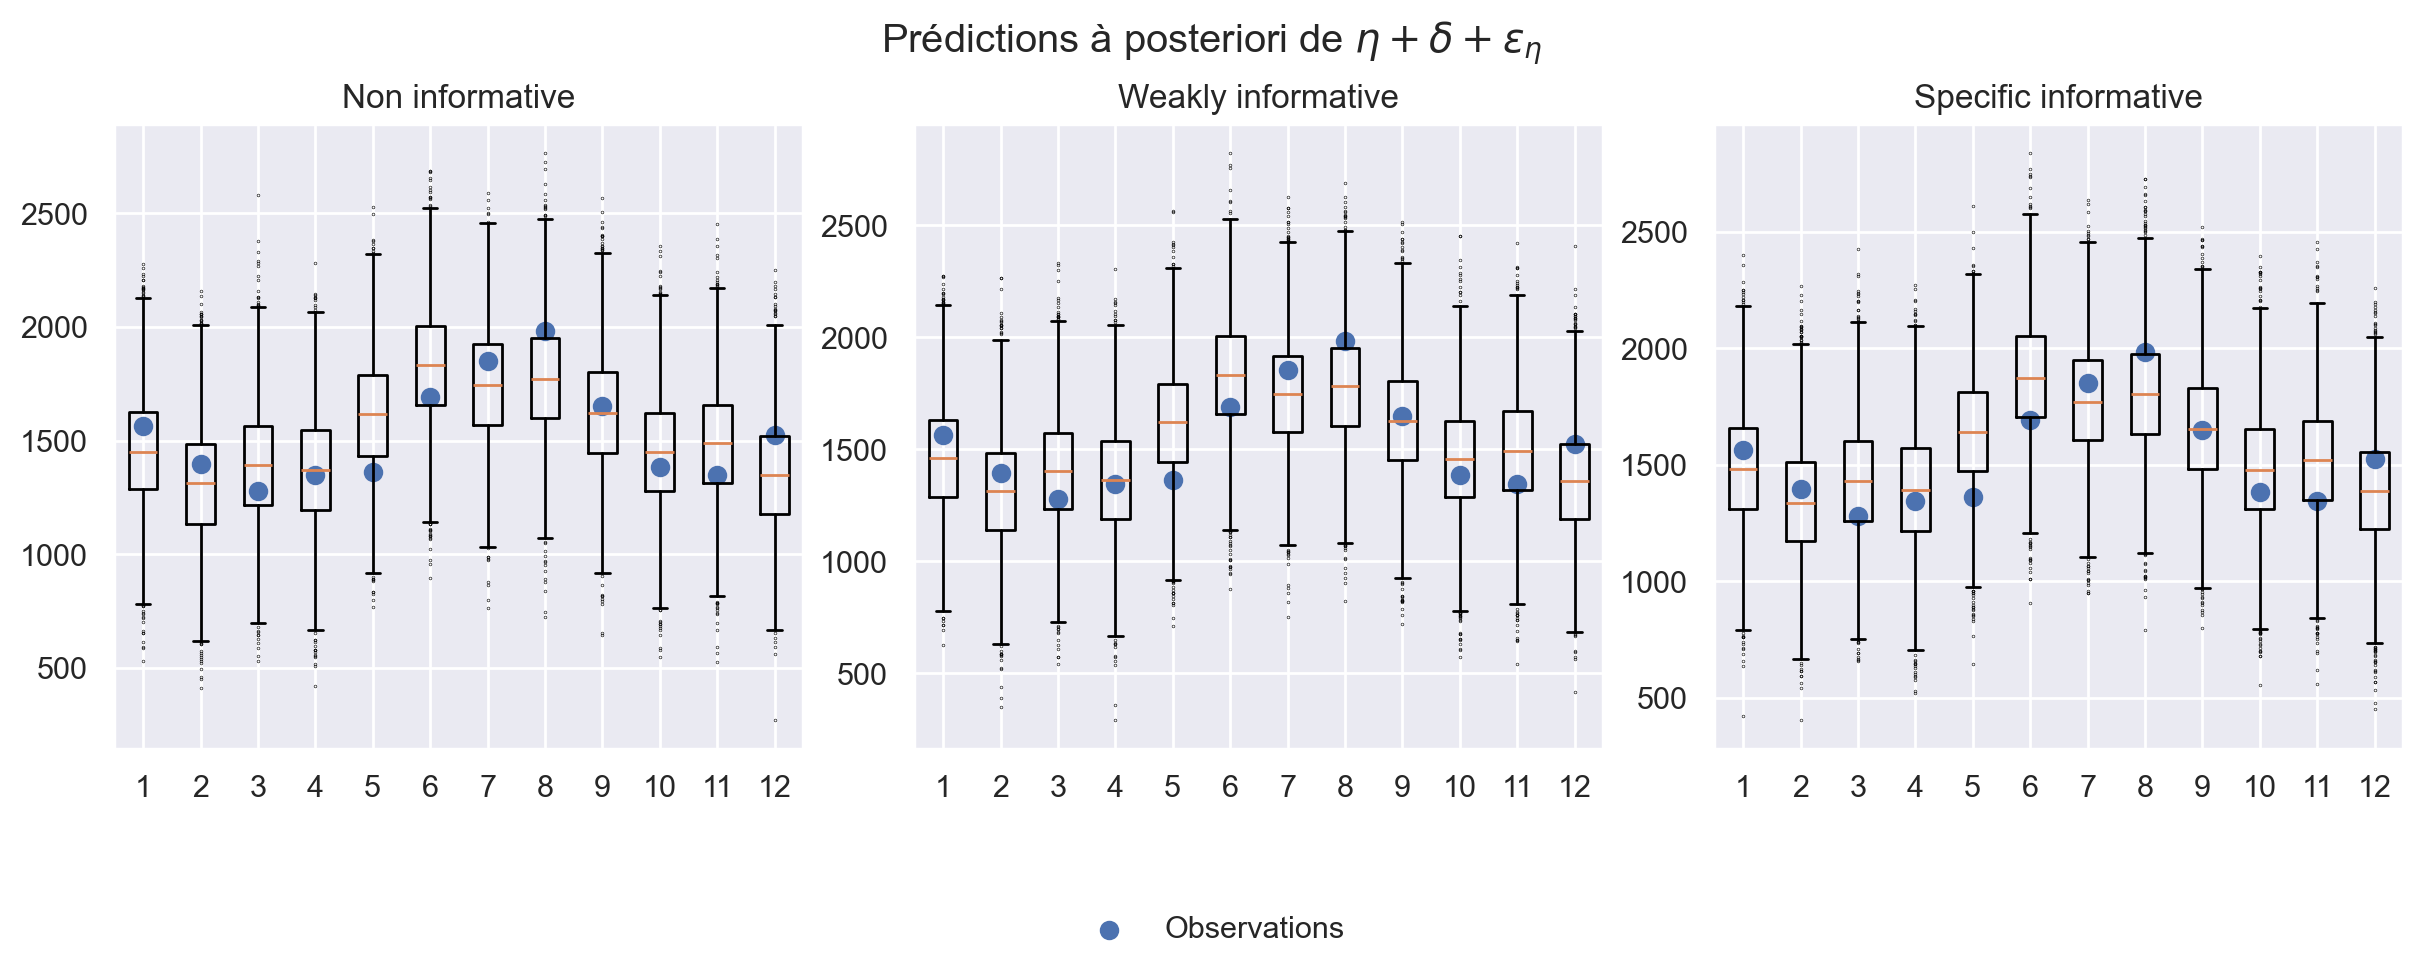

In [43]:
# Prédictions pour chaque prior

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle(r"Prédictions à posteriori de $\eta+\delta+\epsilon_{\eta}$")

axs[0].boxplot(y_pred_NI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[0].scatter(range(1, n+1), y, label = "Observations");
axs[0].set_title("Non informative");

axs[1].boxplot(y_pred_WI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[1].scatter(range(1, n+1), y, label = "Observations");
axs[1].set_title("Weakly informative");

axs[2].boxplot(y_pred_SI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[2].scatter(range(1, n+1), y, label = "Observations");
axs[2].set_title("Specific informative");

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.2));

plt.show()

### Evaluation du modèle avec les critères ASHRAE

Selon la guidelines ASHRAE, des valeurs de $CVRMSE<0.15$ et $NMBE<0.05$ indique que le modèle est bien calibré.

$$CVRMSE = \frac{\sqrt{\frac{\sum_{i=1}^n (y_i-\hat{y_i})^2}{n-1}}}{\bar{y}}$$

$$NMBE = \frac{|\sum_{i=1}^n (y_i-\hat{y_i})|}{(n-1)\bar{y}}$$

In [44]:
# Métriques d'évaluation du modèle calibré

def CVRMSE(y, yhat):
    return np.sqrt(np.sum((y-yhat)**2)/(n-1))/y.mean()

def NMBE(y, yhat):
    return np.abs(np.sum((y-yhat)))/((n-1)*y.mean())

In [45]:
CVRMSE_NI = CVRMSE(y, y_pred_NI.mean(axis = 0))
CVRMSE_WI = CVRMSE(y, y_pred_WI.mean(axis = 0))
CVRMSE_SI = CVRMSE(y, y_pred_SI.mean(axis = 0))
NMBE_NI = NMBE(y, y_pred_NI.mean(axis = 0))
NMBE_WI = NMBE(y, y_pred_WI.mean(axis = 0))
NMBE_SI = NMBE(y, y_pred_SI.mean(axis = 0))


df = pd.DataFrame([[CVRMSE_NI, CVRMSE_WI, CVRMSE_SI],[NMBE_NI, NMBE_WI, NMBE_SI]], index = ["CVRMSE", "NMBE"], 
                  columns = ["Non informative", "Weakly informative", "Specific informative"])
df

Non informative  Weakly informative  Specific informative
CVRMSE         0.093442            0.093148              0.097328
NMBE           0.001088            0.004364              0.025261

### Prédictions de $\eta+\epsilon_{\eta}$

In [46]:
eta_pred_std_NI = np.array(eta_pred(posteriors_NI, num_processors))
eta_pred_std_WI = np.array(eta_pred(posteriors_WI, num_processors))
eta_pred_std_SI = np.array(eta_pred(posteriors_SI, num_processors))

# Remise à l'échelle des prédictions
eta_pred_NI =  eta_pred_std_NI*eta_sd+eta_mean
eta_pred_WI =  eta_pred_std_WI*eta_sd+eta_mean
eta_pred_SI =  eta_pred_std_SI*eta_sd+eta_mean

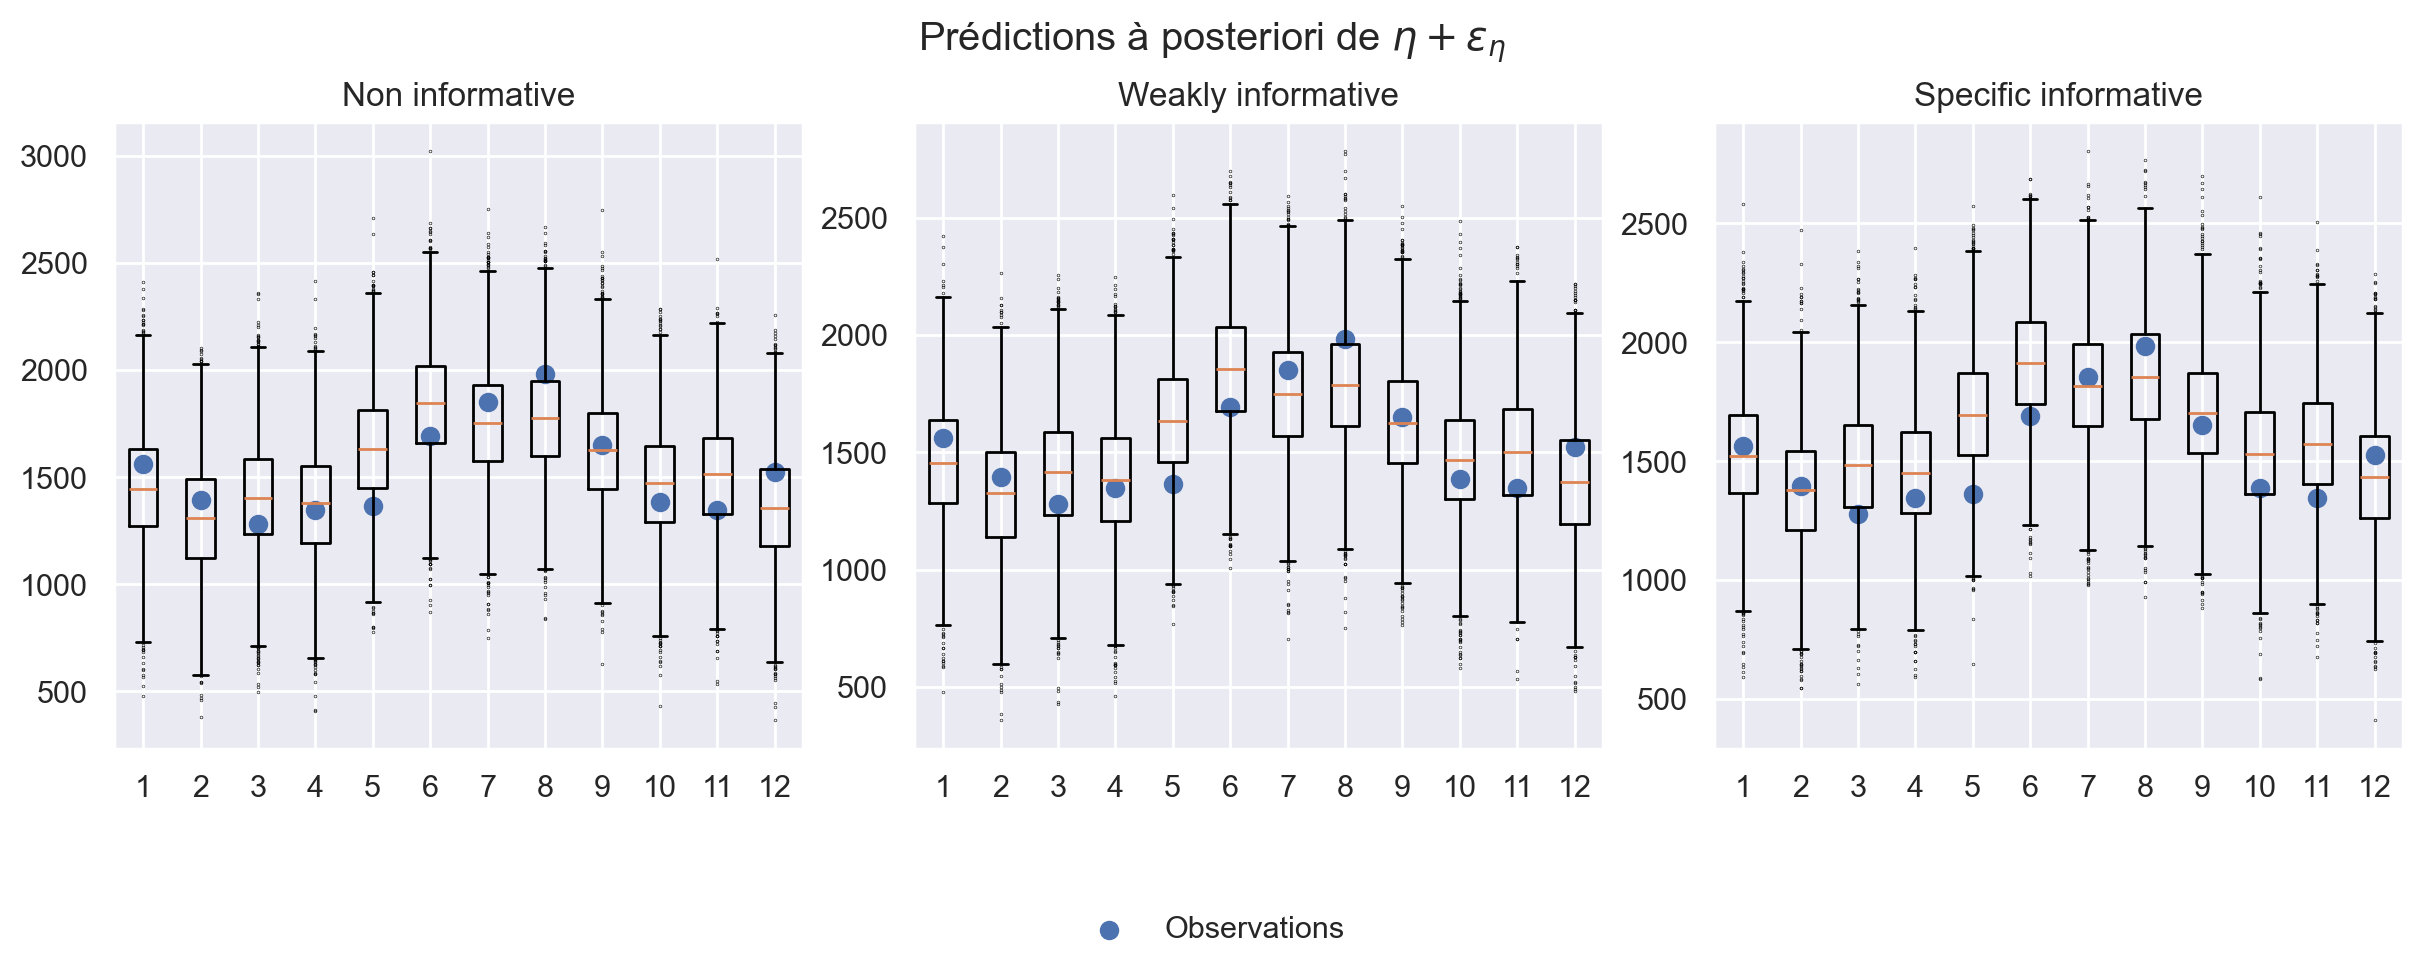

In [47]:
# Prédictions pour chaque prior

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle(r"Prédictions à posteriori de $\eta+\epsilon_{\eta}$")

axs[0].boxplot(eta_pred_NI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[0].scatter(range(1, n+1), y, label = "Observations");
axs[0].set_title("Non informative");

axs[1].boxplot(eta_pred_WI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[1].scatter(range(1, n+1), y, label = "Observations");
axs[1].set_title("Weakly informative");

axs[2].boxplot(eta_pred_SI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[2].scatter(range(1, n+1), y, label = "Observations");
axs[2].set_title("Specific informative");

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.2));

plt.show()

### Prédictions de $\delta$

In [48]:
delta_pred_std_NI = np.array(delta_pred(posteriors_NI, num_processors))
delta_pred_std_WI = np.array(delta_pred(posteriors_WI, num_processors))
delta_pred_std_SI = np.array(delta_pred(posteriors_SI, num_processors))

# Remise à l'échelle des prédictions
delta_pred_NI =  delta_pred_std_NI*eta_sd
delta_pred_WI =  delta_pred_std_WI*eta_sd
delta_pred_SI =  delta_pred_std_SI*eta_sd

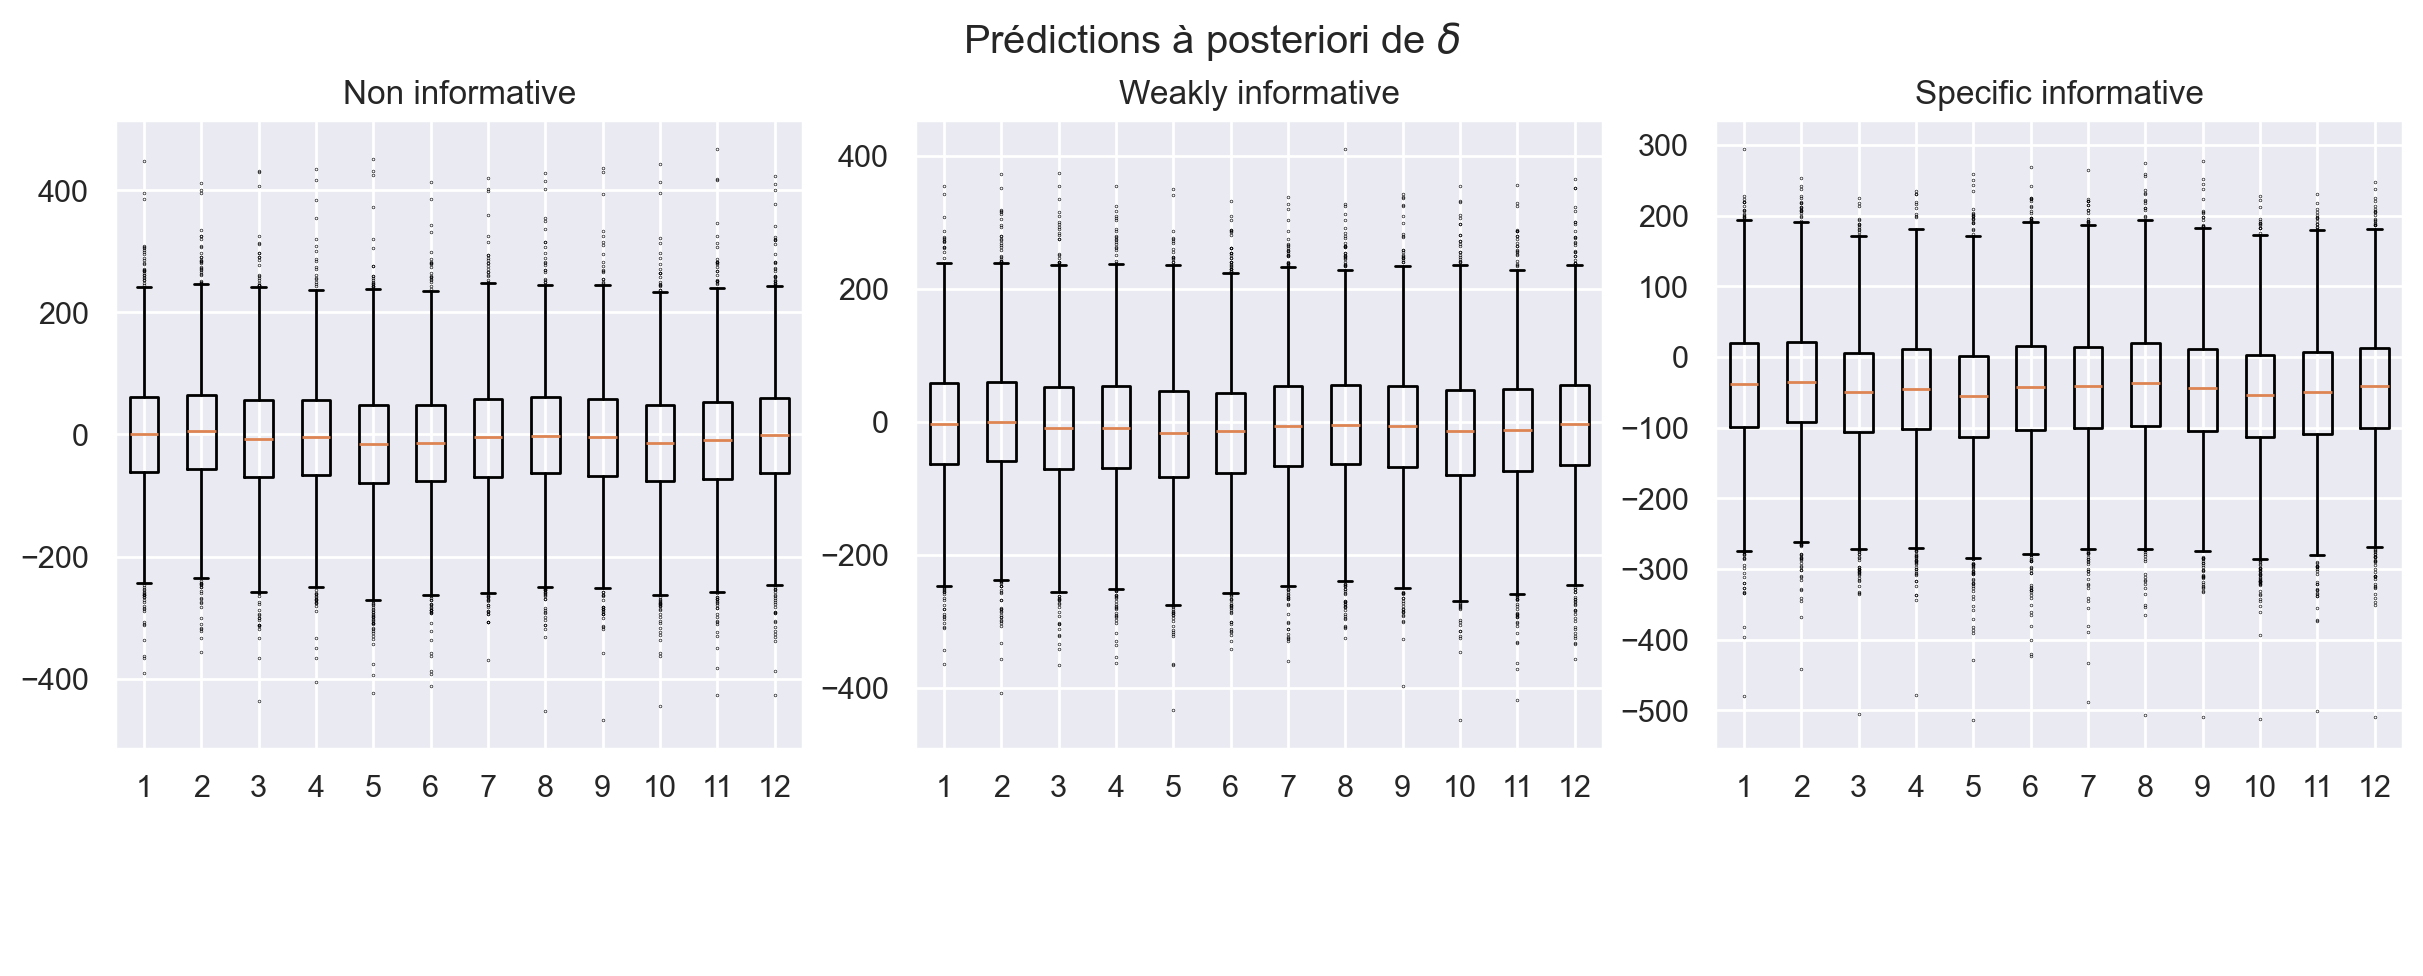

In [49]:
# Prédictions pour chaque prior

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle(r"Prédictions à posteriori de $\delta$")

axs[0].boxplot(delta_pred_NI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[0].set_title("Non informative");

axs[1].boxplot(delta_pred_WI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[1].set_title("Weakly informative");

axs[2].boxplot(delta_pred_SI, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[2].set_title("Specific informative");

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.2));

plt.show()

### Prédictions de $\eta+\delta+\epsilon_{\eta}+\epsilon$

In [50]:
with NI_model:
    pred_samples_NI = pm.sample_posterior_predictive(idataNI, random_seed = rng)

Sampling: [y_mod]


Output()

In [51]:
with WI_model:
    pred_samples_WI = pm.sample_posterior_predictive(idataWI, random_seed = rng)

Sampling: [y_mod]


Output()

In [52]:
with SI_model:
    pred_samples_SI = pm.sample_posterior_predictive(idataSI, random_seed = rng)

Sampling: [y_mod]


Output()

In [53]:
y_pred_std_NI = az.extract(pred_samples_NI, group = "posterior_predictive", var_names = ["y_mod"]).values
y_pred_std_WI = az.extract(pred_samples_WI, group = "posterior_predictive", var_names = ["y_mod"]).values
y_pred_std_SI = az.extract(pred_samples_SI, group = "posterior_predictive", var_names = ["y_mod"]).values

In [54]:
y_pred_NI = y_pred_std_NI*eta_sd+eta_mean
y_pred_WI = y_pred_std_WI*eta_sd+eta_mean
y_pred_SI = y_pred_std_SI*eta_sd+eta_mean

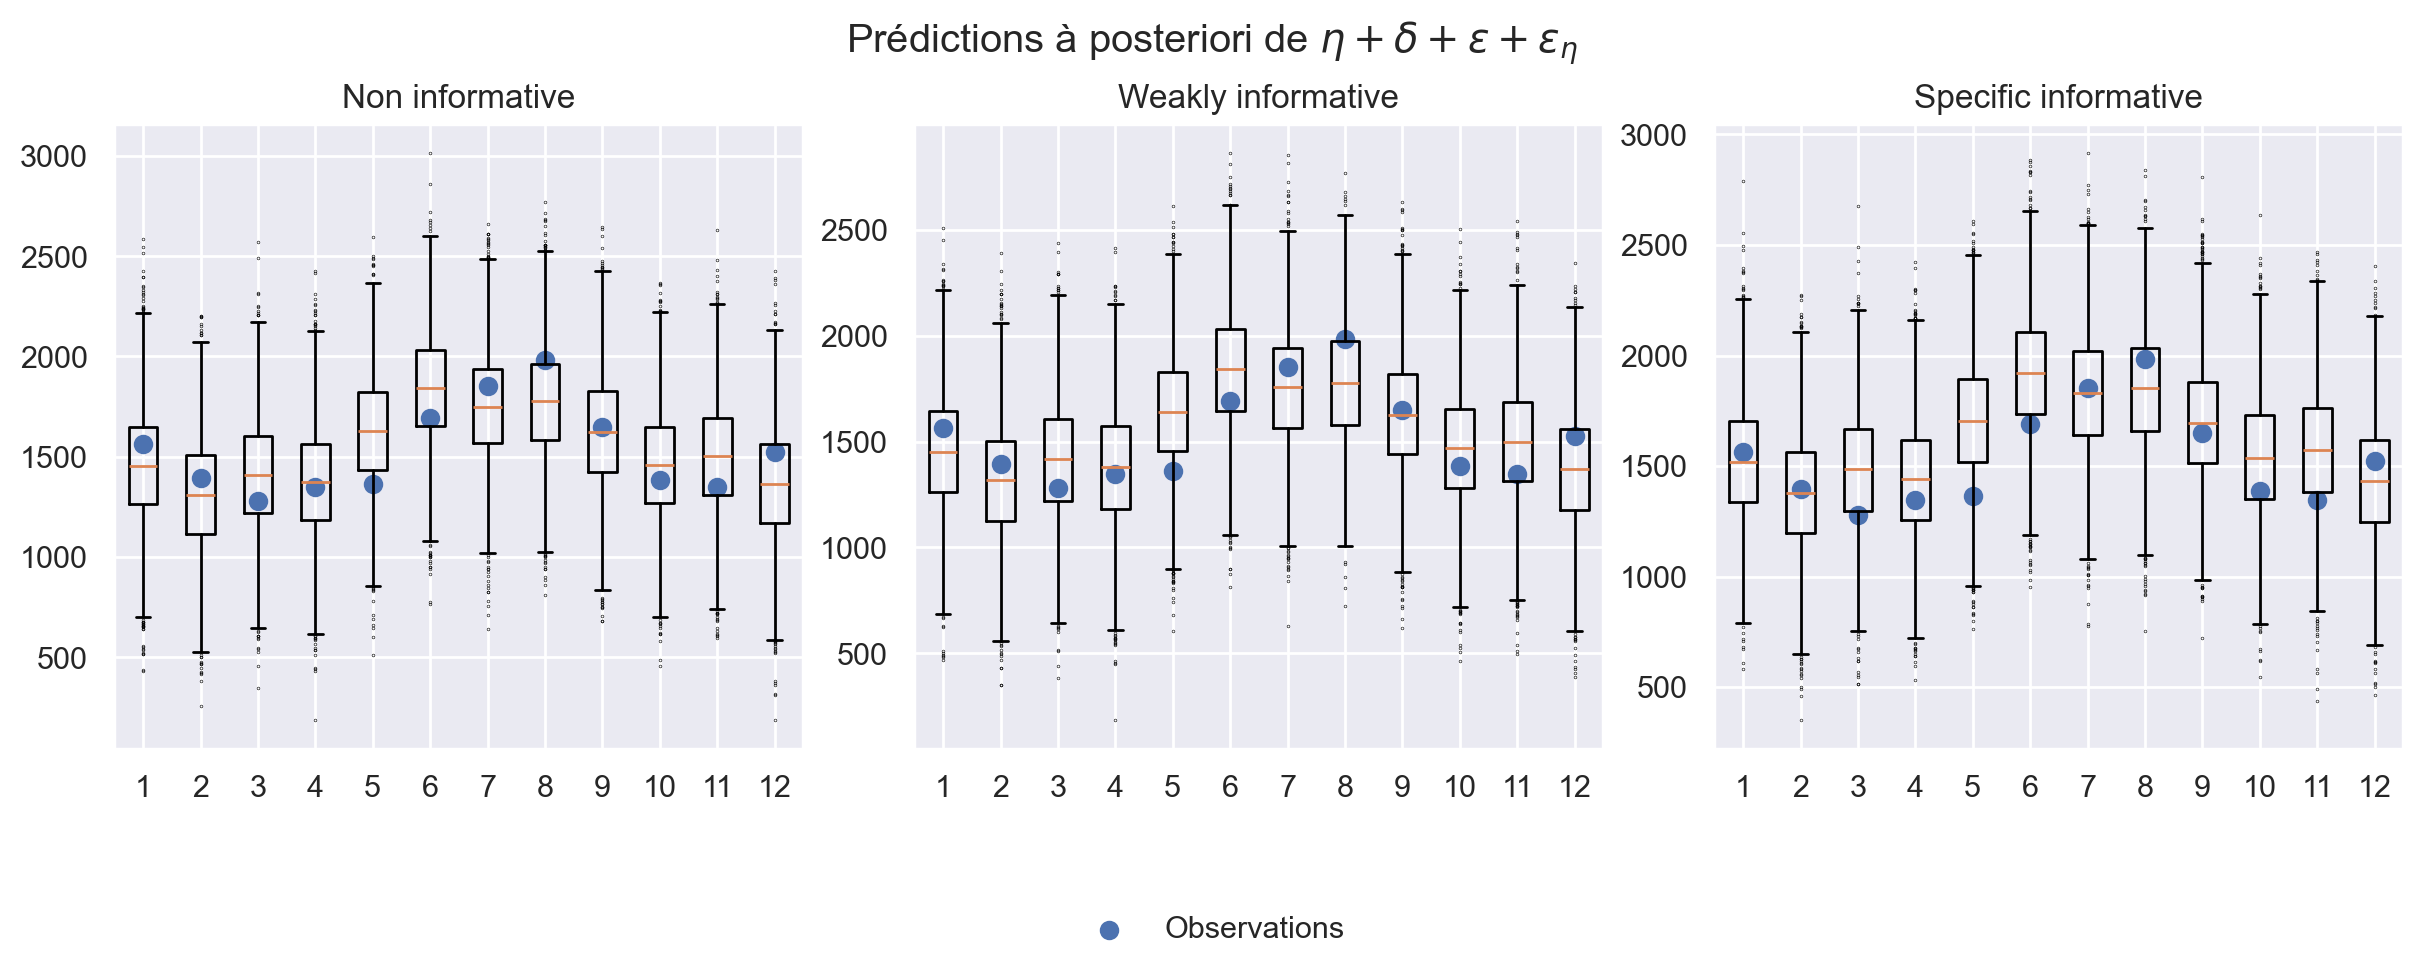

In [55]:
# Prédictions pour chaque prior

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle(r"Prédictions à posteriori de $\eta+\delta+\epsilon+\epsilon_{\eta}$")

axs[0].boxplot(y_pred_NI.T, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[0].scatter(range(1, n+1), y, label = "Observations");
axs[0].set_title("Non informative");

axs[1].boxplot(y_pred_WI.T, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[1].scatter(range(1, n+1), y, label = "Observations");
axs[1].set_title("Weakly informative");

axs[2].boxplot(y_pred_SI.T, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[2].scatter(range(1, n+1), y, label = "Observations");
axs[2].set_title("Specific informative");

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.2));

plt.show()

### Prédictions de $\eta+\delta+\epsilon_{\eta}+\epsilon$ à priori

In [56]:
with NI_model:
    prior_samples_NI = pm.sample_prior_predictive(samples = n_draws, random_seed = rng, var_names = ["y_mod"])

Sampling: [lambda_delta, lambda_eps, rho_delta, tf, y_mod]


In [57]:
with WI_model:
    prior_samples_WI = pm.sample_prior_predictive(samples = n_draws, random_seed = rng, var_names = ["y_mod"])

Sampling: [lambda_delta, lambda_eps, rho_delta, tf, y_mod]


In [58]:
with SI_model:
    prior_samples_SI = pm.sample_prior_predictive(samples = n_draws, random_seed = rng, var_names = ["y_mod"])

Sampling: [lambda_delta, lambda_eps, rho_delta, tf, y_mod]


In [59]:
y_pred_std_NI = az.extract(prior_samples_NI, group = "prior_predictive", var_names = ["y_mod"]).values
y_pred_std_WI = az.extract(prior_samples_WI, group = "prior_predictive", var_names = ["y_mod"]).values
y_pred_std_SI = az.extract(prior_samples_SI, group = "prior_predictive", var_names = ["y_mod"]).values

In [60]:
y_pred_NI = y_pred_std_NI*eta_sd+eta_mean
y_pred_WI = y_pred_std_WI*eta_sd+eta_mean
y_pred_SI = y_pred_std_SI*eta_sd+eta_mean

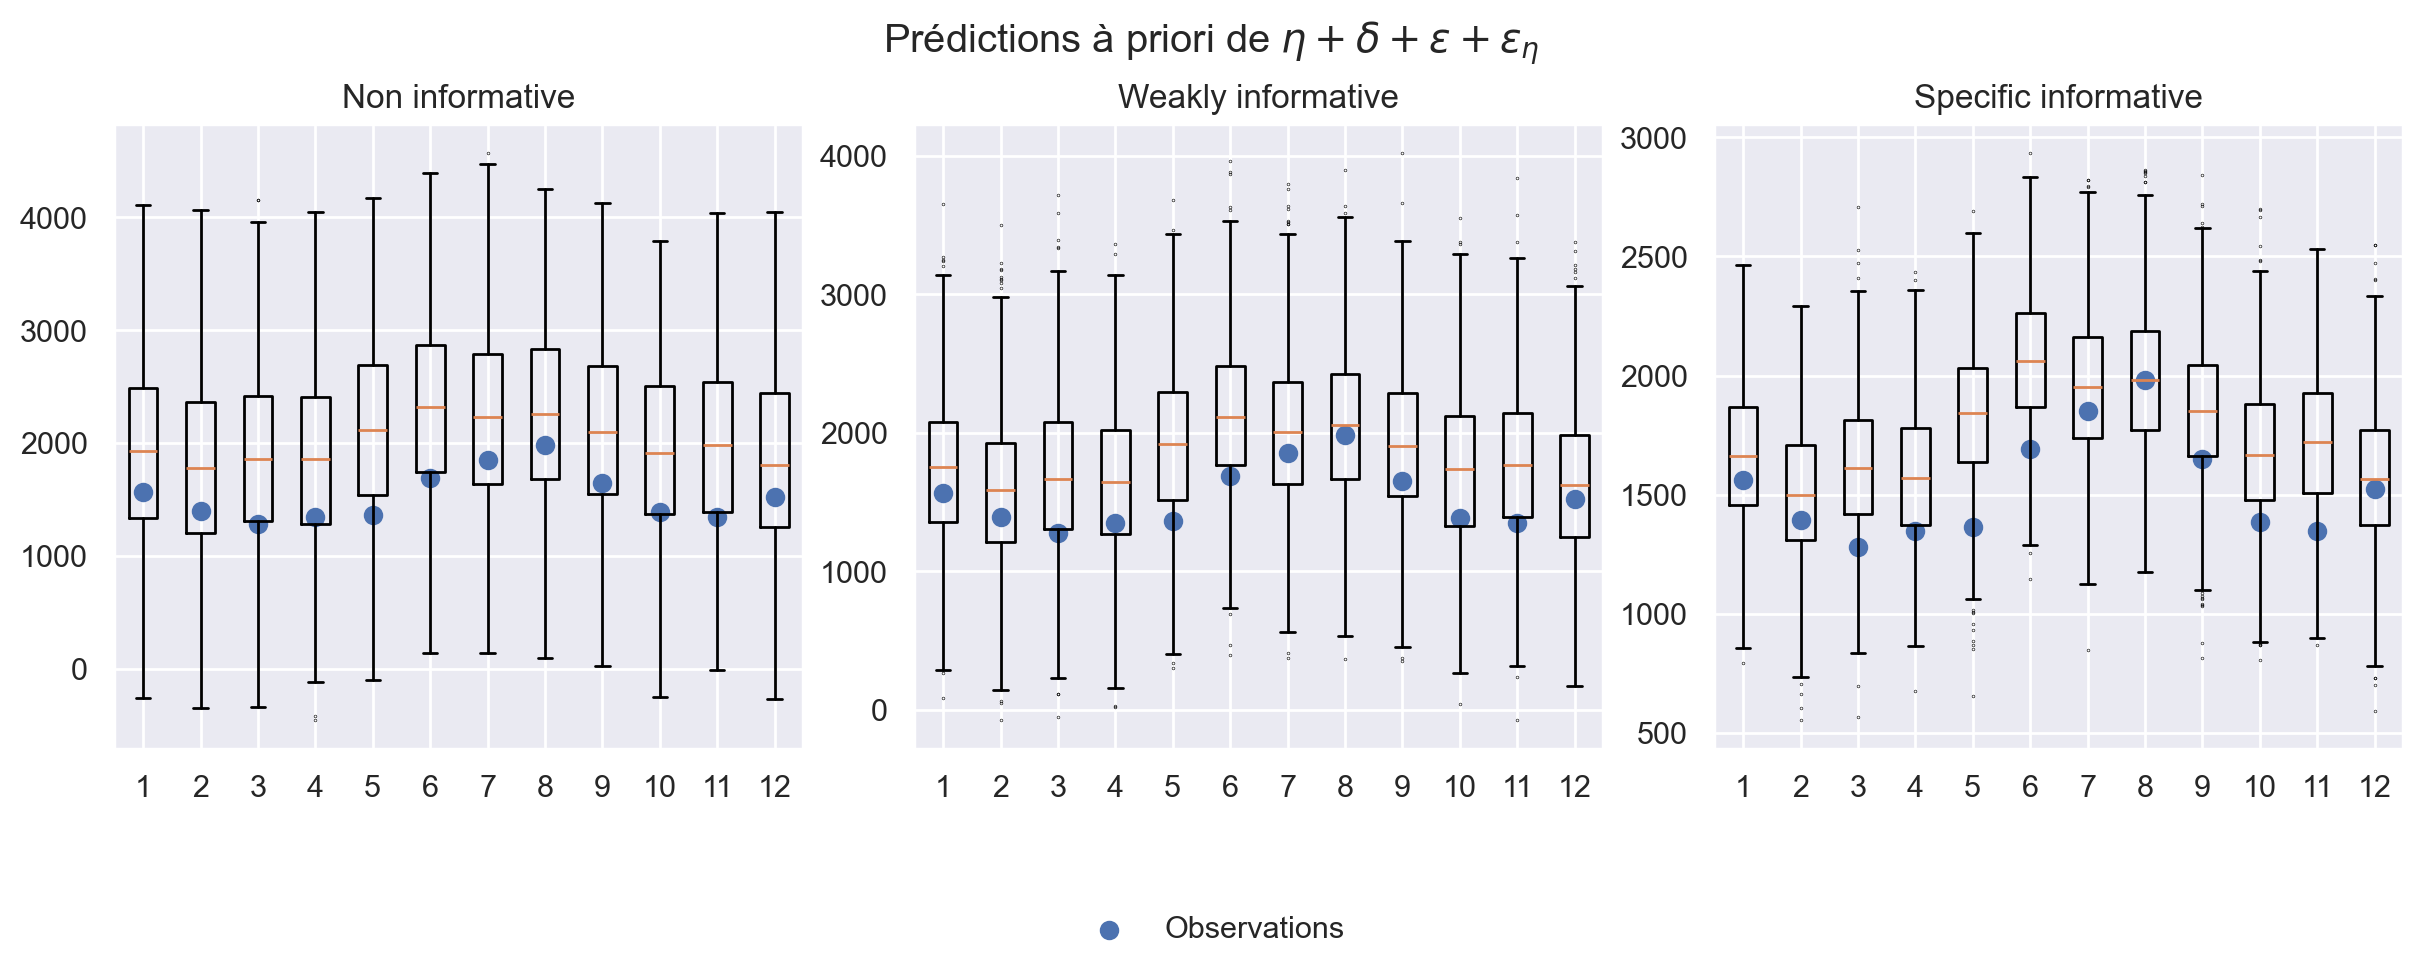

In [61]:
# Prédictions pour chaque prior

fig, axs = plt.subplots(1, 3, figsize = (12, 4))

fig.suptitle(r"Prédictions à priori de $\eta+\delta+\epsilon+\epsilon_{\eta}$")

axs[0].boxplot(y_pred_NI.T, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[0].scatter(range(1, n+1), y, label = "Observations");
axs[0].set_title("Non informative");

axs[1].boxplot(y_pred_WI.T, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[1].scatter(range(1, n+1), y, label = "Observations");
axs[1].set_title("Weakly informative");

axs[2].boxplot(y_pred_SI.T, positions = range(1, n+1), flierprops = dict(markersize = 0.2));
axs[2].scatter(range(1, n+1), y, label = "Observations");
axs[2].set_title("Specific informative");

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.2));

plt.show()

# <p style="text-align: center;">Fin</p>